# Homework 4

This is a homework assignment on the material about the `Variance reduction techniques and Distributed Optimisation basic ideas`.

__Soft Deadline__: +2 weeks after the release date: __5 Dec 2024, 23:59__

<span style="color:red">__Soft Deadline__ = __Hard Deadline__</span>.

- The homework is done in the same Jupyter Notebook. *Please, read all problems first, then decide how to distribute your time. The homework is interesting, but a bit time consuming!*
- The submission should be in the following format: **YourName_HW4.ipynb**.
- Do not forget to add necessary explanations and comments.
- You are free to modify the function templates and use additional libraries. However, do not use built-in functions if the assignment requires you to implement the method from scratch.


- __The works will be checked for plagiarism. The score will be divided by the number of similar works.__

- A full run of the solution (Kernel -> Restart & Run All) should run all cells without errors.

- The maximum score for the assignment is `20 + 6 (bonus)`.
_To get a full score for the hometask you need to get 20._

We wish you success!

## Variance Reduced SGD

***We continue to work with the stochastic optimisation of LogReg (:***

\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}
where $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ is a loss function, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ is a model, $w$ are parameters of the model, $\{x_i, y_i\}_{i=1}^n$ is data of objects $x_i \in \mathbb{R}^x$ and labels $y_i \in \mathbb{R}$.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoid loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Important: $y$ must take values $-1$ or $1$__). As we already know, the resulting problem is called a logistic regression problem.

This problem can be rewritten as follows:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{s} \sum\limits_{j=1}^s f_j(w) := \frac{1}{s} \sum\limits_{j=1}^s \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_{(j-1)b + i}), y_{(j-1)b + i}) + \frac{\lambda}{2} \| w\|^2_2\right],
\end{equation}
where $b$ is the batch size, $s$ is the number of batches, and $b s = n$ is the total sample size.

The gradient of $f_j$:
$$
\nabla f_j(w) = \frac{1}{b} \sum_{i=1}^b \frac{-y_{(j-1)b + i} x_{(j-1)b + i}}{1 + \exp(y_{(j-1)b + i} w^Tx_{(j-1)b + i})}.
$$
The Lipschitz constant of the gradient $\nabla f_j$ can be estimated as $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2$.

We continue to work with _mushrooms_ dataset.

In [3]:
dataset = "mushrooms.txt" # '/content/mushrooms.txt' 
#the file must be in the same directory as notebook.

In [4]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

Let us change the vector $y$ so that $y_i$ takes values $-1$ and $1$. You can also do additional preprocessing of the data (with techniques from machine learning), but this is not additionally assessed in any way.

In [5]:
y = 2 * y - 3

Let us divide the data into two parts: training and test.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For the training part $X_{train}$, $y_{train}$, estimate the constant $L$. Set $\lambda$ such that $\lambda \approx L / 1000$.  Realize in the code the calculation of the value and gradient for our target function ($X$, $y$, $\lambda$ should be given as a parameter so that it is possible to change them, not only to substitute fixed $X_{train}$, $y_{train}$). You can use ``numpy``, or ``autograd``, ``pytorch``, ``jax``.

In [7]:
! pip install autograd

  Using cached autograd-1.7.0-py3-none-any.whl.metadata (7.5 kB)
Using cached autograd-1.7.0-py3-none-any.whl (52 kB)



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Consider a given batch, $X_{b, j}$
Then, $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2 = \frac{1}{4b} \sum\limits_{i=1}^b x_{(j-1)b + i}^Tx_{(j-1)b + i} = \frac{1}{4b}\text{trace}(X_{b, j}^TX_{b, j})$

In [8]:
#your solution (Code and Markdown)
import numpy as np
# To estimate L from train sets
L = np.trace(X_train.T @ X_train)/(4*X_train.shape[0])

In [9]:
regularizer = L/1000 # lambda

def L_estimate(batch = X_train):
    return np.trace(batch.T @ batch)/(4*batch.shape[0])

def cost(w, x, y, regularizer = regularizer):
    '''
    Evaluates the cost function

    Parameters
    w:           numpy array containing weights of the model
    x:           numpy array containing features of the data point
    y:           numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    loss: the value of the cost function of a data batch for a given set of weights
    '''
    n = len(y)
    loss = 0
    g = (x @ w).flatten()
    y = y.flatten()
    for i in range(n):
        l = np.log(1 + np.exp(-y[i]*g[i]))
        loss += l
    loss /= n
    loss += regularizer * np.sum(w.T @ w)
    return loss

import autograd
import autograd.numpy as anp

def cost1(w, x, y, regularizer = regularizer):
    '''
    Evaluates the cost function

    Parameters
    w:           autograd.numpy array containing weights of the model
    x:           autograd.numpy array containing features of the data point
    y:           autograd.numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    loss: the value of the cost function of a data batch for a given set of weights
    '''
    n = len(y)
    loss = 0
    g = (x @ w).flatten()
    y = y.flatten()
    for i in range(n):
        l = anp.log(1 + anp.exp(-y[i]*g[i]))
        loss += l
    loss /= n
    loss += regularizer * anp.sum(w.T @ w)
    return loss

formula = False
def gradient(w, x, y, formula = formula, regularizer = regularizer):
    '''
    Evaluates the gradient function

    Parameters
    w:           numpy array containing weights of the model
    x:           numpy array containing features of the data point
    y:           numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    grad: the value of the gradient function of a data batch for a given set of weights
    '''
    # def dfdx_i(f: callable,
    #            x: np.ndarray,
    #            i=0,
    #            eps=1e-3
    #           ):
    #     out = np.zeros_like(x)
    #     out[i] = eps
    #     return (f(x + out) - f(x - out))/2/eps

    f = lambda w: cost1(w, x, y)
    if formula:
        g = (x @ w).flatten()
        grad = np.zeros_like(x[0])
        for i in range(len(y)):
            denominator = 1 + np.exp(y[i] * g[i])
            numerator = - y[i] * x[i]
            grad += numerator / denominator
        grad += regularizer * w              # Similar mistake with previous HW, so I added the missing lambda
        return grad
    else:
        # grad = [dfdx_i(f, np.zeros_like(x[0]), i) for i in range(len(x[0]))]  Too slow
        # grad += regularizer * w
        return autograd.grad(f)(w)                                            # Faster

def predict(w, x):
    '''
    Predicts the class, given a set of weights and features

    Parameters
    w:           numpy array containing weights of the model
    x:           numpy array containing features of the data point

    Returns:
    y_pred: numpy array of predicted labels
    '''
    g = (x @ w).flatten()
    y_pred = (g >= 0) + (g < 0)*-1
    return y_pred.flatten()

In [10]:
import time
start = time.time()
gradient(np.zeros_like(X_train[0]), X_train, y_train, formula = True)
end = time.time()
print(end-start)
start = time.time()
gradient(np.zeros_like(X_train[0]), X_train, y_train, formula = False)
end = time.time()
print(end-start)

0.06405305862426758
1.4924540519714355


**$\textcolor{red}{Pre-setup}$**

Please, put in the cell bellow the batch splitting procedure from the previous assignment here:

In [11]:
# Just BATCH IT!

def split_data(b: int, data: tuple[np.array] = (X_train, y_train)) -> list:
    '''
    Parameters:
    b: Batchsizes of each data
    data: Tuple of numpy arrays

    Returns:
    out: list of tuples of numpy arrays
    '''
    out = []
    for i in range(0, len(data[1]), b):
        out.append((data[0][i: i+b], data[1][i: i+b]))
    return tuple(out)

**Problem 1. (2 points)**

Implement the SGD method `with momentum` **(1 point)**:
\begin{equation}
\begin{aligned}
    &w^{k+1} = w^{k} - \gamma g^{k} \\
    &g^{k+1} = (1 - b) g^{k} + b \nabla f_{j_k}(w^{k+1}),
\end{aligned}
\end{equation}
    
where the number $j_k$ is generated independently and uniformly from $\{1, \ldots, s \}$,
$b \in [0, 1]$ is a *momentum* parameter.

For the tasks below, you may need to be able to measure the running time of the method.

In [12]:
# your solution
import time
from tqdm import tqdm
import random

def Momentum_SGD(nabla_f, w_0, gamma, beta, b,
                K = 1000, eps = 1e-6, data = (X_train, y_train)):
    '''
    Finds the zero of nabla_f using stochastic gradient descent with momentum

    Parameters
    nabla_f:   Gradient of the cost function
    w_0    :   Start point
    gamma  :   Learning rate
    beta   :   Hyper parameter for momentum
    b      :   Batch size
    K      :   Number if iterations
    eps    :   Accuracy
    data   :   Data to train the algorithm on

    Return
    w_opt  :   Optimal point found by the algorithm
    path   :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]
    '''
    start = time.time()
    batches = split_data(b, data)
    s = len(batches)
    g_prev = np.random.rand(X_train[0].shape[0])
    w_prev = w_0
    path = []
    C = np.linalg.norm(nabla_f(w_0, data[0], data[1]))
    for k in tqdm(range(K)):
        batch = batches[random.randint(0, s-1)]
        w_new = w_prev - gamma(k) * g_prev
        # gradient(w, x, y)
        g_new = (1 - beta) * g_prev + beta * nabla_f(w_new, batch[0], batch[1])
        path.append(np.linalg.norm(w_new - w_prev)/C)
        if np.all(np.abs(w_new - w_prev) <= eps):
            break
        w_prev = w_new
        g_prev = g_new
    w_opt = w_new
    end = time.time()
    print(f'SGD implementation with Momentum for batchsize {b}, beta {beta}, took {end - start} seconds')
    return w_opt, path

And implement the `MVR` variant of SGD **(1 point)**:
\begin{equation}
\begin{aligned}
    &w^{k+1} = w^{k} - \gamma g^{k} \\
    &g^{k+1} = (1 - b) g^{k} + b \nabla f_{j_k}(w^{k+1}) + \textcolor{cyan}{(1 - b) \left(\nabla f_{j_k}(w^{k+1}) - \nabla f_{j_k}(w^{k})\right)}
\end{aligned}
\end{equation}

Don't forget about time measurements

In [13]:
# your solution

def MVR_SGD(nabla_f, w_0, gamma, beta, b,
            K = 1000, eps = 1e-6, data = (X_train, y_train)):
    '''
    Finds the zero of nabla_f using stochastic gradient descent with momentum

    Parameters
    nabla_f:   Gradient of the cost function
    w_0    :   Start point
    gamma  :   Learning rate
    beta   :   Hyper parameter for momentum
    b      :   Batch size
    K      :   Number if iterations
    eps    :   Accuracy
    data   :   Data to train the algorithm on

    Return
    w_opt  :   Optimal point found by the algorithm
    path   :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]
    '''
    start = time.time()
    batches = split_data(b, data)
    s = len(batches)
    g_prev = np.random.rand(X_train[0].shape[0])
    w_prev = w_0
    C = np.linalg.norm(nabla_f(w_0, data[0], data[1]))
    path = []
    for k in tqdm(range(K)):
        batch = batches[random.randint(0, s-1)]
        w_new = w_prev - gamma(k) * g_prev
        # gradient(w, x, y)
        nab_w1 = nabla_f(w_new, batch[0], batch[1])
        nab_w0 = nabla_f(w_prev, batch[0], batch[1])
        g_new = (1 - beta) * g_prev + beta * nab_w1  + (1 - beta) * (nab_w1 - nab_w0)
        path.append(np.linalg.norm(w_new - w_prev)/C)
        if np.all(np.abs(w_new - w_prev) <= eps):
            break
        w_prev = w_new
        g_prev = g_new
    w_opt = w_new
    end = time.time()
    print(f'MVR SGD implementation for batchsize {b}, beta {beta}, took {end - start} seconds')
    return w_opt, path

**Problem 2. (4 points + 2 bonus)**

Great!

Now, using the existing implementation of SGD from the previous assignment...  

In [14]:
# Put SGD from the previous assignment here
def SGD(nabla_f, w_0, gamma, b,
        K = 1000, eps = 1e-6, data = (X_train, y_train)):
    '''
    Finds the zero of nabla_f using stochastic gradient descent with momentum

    Parameters
    nabla_f:   Gradient of the cost function
    w_0    :   Start point
    gamma  :   Learning rate
    b      :   Batch size
    K      :   Number if iterations
    eps    :   Accuracy
    data   :   Data to train the algorithm on

    Return
    w_opt  :   Optimal point found by the algorithm
    path   :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]
    '''
    start = time.time()
    batches = split_data(b, data)
    s = len(batches)
    w_prev = w_0
    C = np.linalg.norm(nabla_f(w_0, data[0], data[1]))
    path = []
    for k in tqdm(range(K)):
        batch = batches[random.randint(0, s-1)]
        w_new = w_prev - gamma(k) * nabla_f(w_prev, batch[0], batch[1])

        path.append(np.linalg.norm(w_new - w_prev)/C)
        if np.all(np.abs(w_new - w_prev) <= eps):
            break
        w_prev = w_new
    w_opt = w_new
    end = time.time()
    print(f'SGD implementation for batchsize {b}, took {end - start} seconds')
    return w_opt, path

*(1 points)*

Solve the optimization problem on the training sample using the implemented methods: `SGD, SGD+Momentum, MVR`.

Take again: $\text{batch\_size } = 10$,$\gamma_k \equiv \frac{1}{L}$. Draw the convergence plot wtih the same criteria (e.g. $\frac{\| \nabla f(w^k)\|}{\| \nabla f(w^0)\|}$) from the iteration number.

Make a conclusions about the reduction of variance for 2 modifications.

Do we see the biased behaviour for the MVR here? Why?

100%|██████████| 1000/1000 [00:02<00:00, 463.10it/s]


SGD implementation for batchsize 10, took 3.6727781295776367 seconds


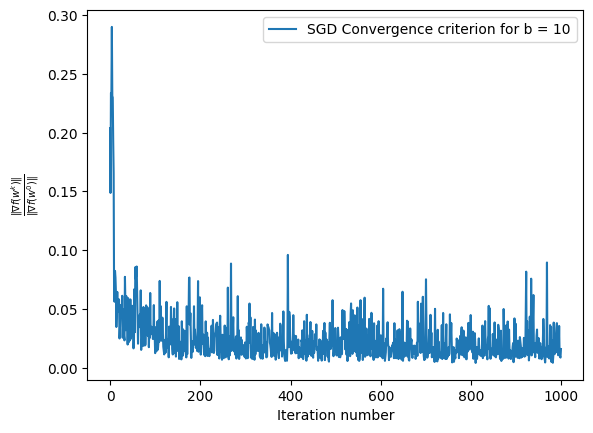

100%|██████████| 1000/1000 [00:02<00:00, 473.80it/s]


SGD implementation with Momentum for batchsize 10, beta 0.2, took 3.739043712615967 seconds


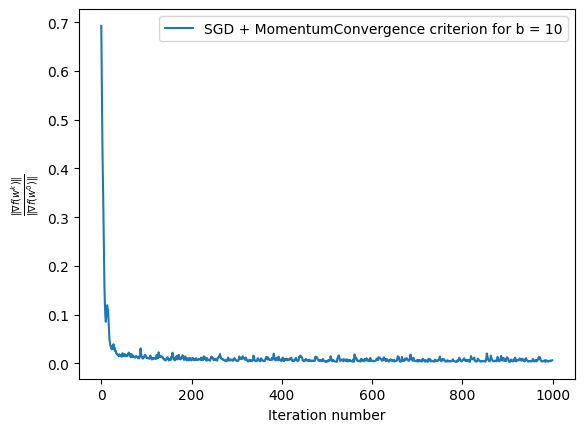

100%|██████████| 1000/1000 [00:03<00:00, 266.76it/s]


MVR SGD implementation for batchsize 10, beta 0.2, took 5.121809959411621 seconds


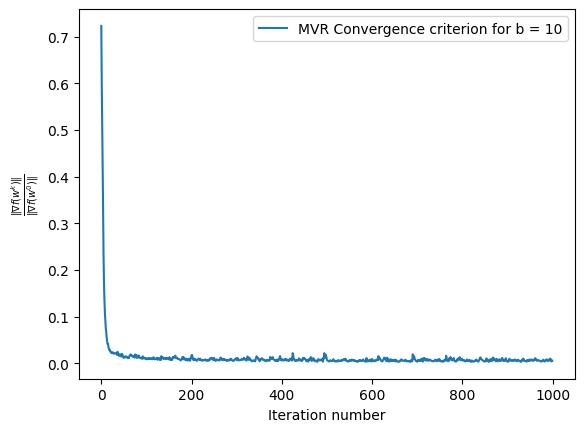

In [15]:
# your solution here
import matplotlib.pyplot as plt
%matplotlib inline

b = 10
gamma = lambda x: 1/L
w_0 = np.random.rand(X_train[0].shape[0])

w_opt1, path1 = SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, b = b)
x_cord1 = [i for i in range(len(path1))]
plt.plot(x_cord1, path1, label = f'SGD Convergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

beta = 0.2

w_opt2, path2 = Momentum_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b)
x_cord2 = [i for i in range(len(path2))]
plt.plot(x_cord2, path2, label = f'SGD + MomentumConvergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

w_opt3, path3 = MVR_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b)
x_cord3 = [i for i in range(len(path3))]
plt.plot(x_cord3, path3, label = f'MVR Convergence criterion for b = {b}')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

For this batch size, there is observable difference difference between MVR and Momentum in terms of variance of the convergence (although little). MVR seems to be the slowest.

*(1.6 points)*

When you understand that the implementation works ~~somehow~~, repeat the research (from the previous assignment) of hyperparameters for all 3 methods and compare them.

- $\text{batch\_size}: 1, 10, 100, 1000$, $\gamma_k \equiv \frac{1}{L}$ with the standart convergence criteria (previous one) from the iterations
- same for the criteria from the oracle calls (the amount of gradient calls on batch) or time
- $\text{batch\_size}= 10$, $\gamma_k: \frac{1}{L}, \frac{1}{\sqrt{k + 1}}, \gamma_k = \frac{1}{k + 1}$.

Can you see something interesting now? Is the varience really reduced?

How does the variance reduction influence the time dependency?
Any other thoughts?...

100%|██████████| 1000/1000 [00:00<00:00, 1758.98it/s]


SGD implementation for batchsize 1, took 2.047999858856201 seconds


100%|██████████| 1000/1000 [00:00<00:00, 1759.72it/s]


SGD implementation with Momentum for batchsize 1, beta 0.2, took 1.8866682052612305 seconds


100%|██████████| 1000/1000 [00:01<00:00, 971.99it/s]


MVR SGD implementation for batchsize 1, beta 0.2, took 2.29258394241333 seconds


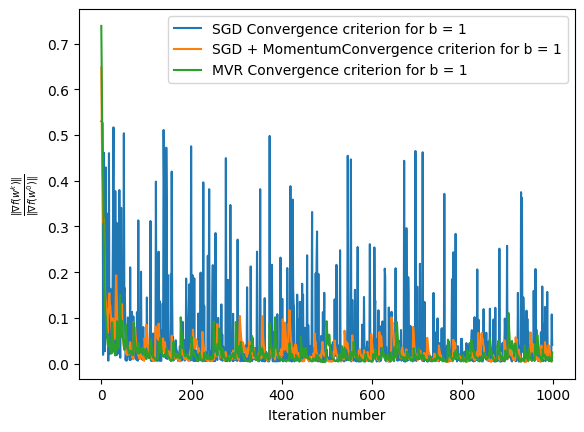

100%|██████████| 1000/1000 [00:01<00:00, 519.50it/s]


SGD implementation for batchsize 10, took 3.1019623279571533 seconds


100%|██████████| 1000/1000 [00:01<00:00, 560.57it/s]


SGD implementation with Momentum for batchsize 10, beta 0.2, took 3.1156487464904785 seconds


100%|██████████| 1000/1000 [00:03<00:00, 275.50it/s]


MVR SGD implementation for batchsize 10, beta 0.2, took 4.904061794281006 seconds


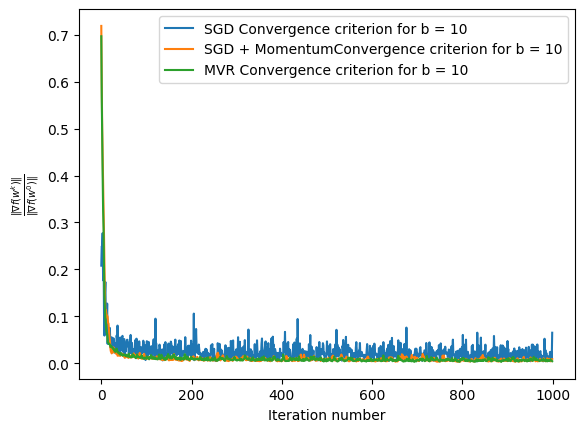

100%|██████████| 1000/1000 [00:18<00:00, 54.26it/s]


SGD implementation for batchsize 100, took 19.85106611251831 seconds


100%|██████████| 1000/1000 [00:18<00:00, 54.03it/s]


SGD implementation with Momentum for batchsize 100, beta 0.2, took 19.89340043067932 seconds


100%|██████████| 1000/1000 [00:36<00:00, 27.07it/s]


MVR SGD implementation for batchsize 100, beta 0.2, took 38.336766481399536 seconds


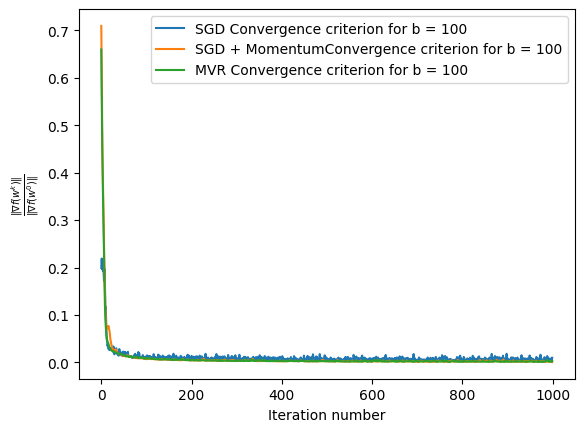

100%|██████████| 1000/1000 [03:19<00:00,  5.01it/s]


SGD implementation for batchsize 1000, took 201.2983684539795 seconds


100%|██████████| 1000/1000 [03:14<00:00,  5.15it/s]


SGD implementation with Momentum for batchsize 1000, beta 0.2, took 195.52517080307007 seconds


100%|██████████| 1000/1000 [06:29<00:00,  2.56it/s]


MVR SGD implementation for batchsize 1000, beta 0.2, took 391.20741987228394 seconds


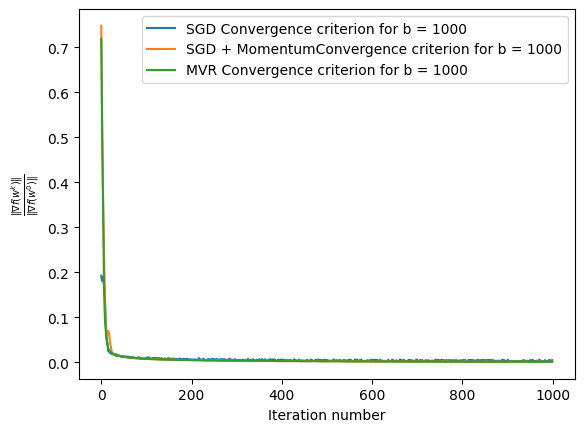

In [16]:
# your solution here
import math
def tests(b = 10, gamma = lambda x: 1/L, beta = 0.2, K = 1000):
    w_0 = np.random.rand(X_train[0].shape[0])

    w_opt1, path1 = SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, b = b, K = K)
    x_cord1 = [i for i in range(len(path1))]
    plt.plot(x_cord1, path1, label = f'SGD Convergence criterion for b = {b}')
    plt.xlabel('Iteration number')
    plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
    # plt.legend()
    # plt.show()

    w_opt2, path2 = Momentum_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = K)
    x_cord2 = [i for i in range(len(path2))]
    plt.plot(x_cord2, path2, label = f'SGD + MomentumConvergence criterion for b = {b}')
    # plt.xlabel('Iteration number')
    # plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
    # plt.legend()
    # plt.show()

    w_opt3, path3 = MVR_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = K)
    x_cord3 = [i for i in range(len(path3))]
    plt.plot(x_cord3, path3, label = f'MVR Convergence criterion for b = {b}')
    # plt.xlabel('Iteration number')
    # plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
    plt.legend()
    plt.show()

batch_size = [1, 10, 100, 1000]
for b in batch_size:
    tests(b)

100%|██████████| 1000/1000 [00:00<00:00, 1671.84it/s]


SGD implementation for batchsize 1, took 2.0608575344085693 seconds


100%|██████████| 1000/1000 [00:00<00:00, 1243.54it/s]


SGD implementation with Momentum for batchsize 1, beta 0.2, took 2.3688628673553467 seconds


100%|██████████| 1000/1000 [00:01<00:00, 820.91it/s]


MVR SGD implementation for batchsize 1, beta 0.2, took 2.5174496173858643 seconds


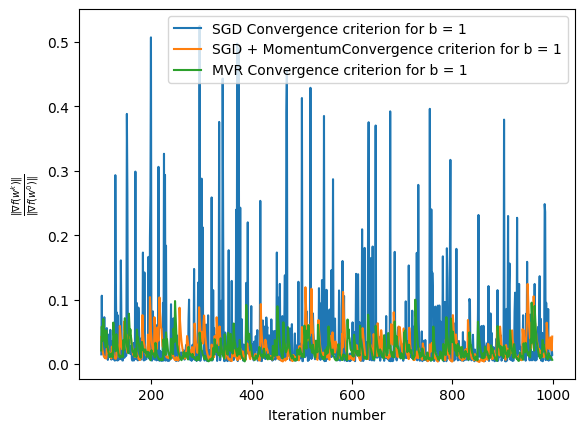

100%|██████████| 1000/1000 [00:02<00:00, 461.44it/s]


SGD implementation for batchsize 10, took 3.766685724258423 seconds


100%|██████████| 1000/1000 [00:02<00:00, 479.14it/s]


SGD implementation with Momentum for batchsize 10, beta 0.2, took 3.4010252952575684 seconds


100%|██████████| 1000/1000 [00:04<00:00, 245.33it/s]


MVR SGD implementation for batchsize 10, beta 0.2, took 5.362242698669434 seconds


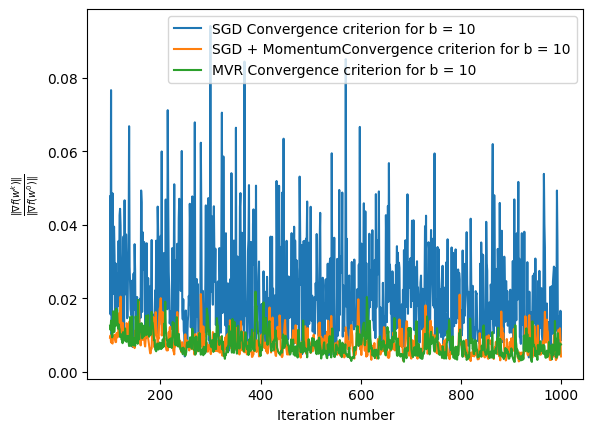

100%|██████████| 1000/1000 [00:20<00:00, 49.95it/s]


SGD implementation for batchsize 100, took 21.599422454833984 seconds


100%|██████████| 1000/1000 [00:20<00:00, 49.32it/s]


SGD implementation with Momentum for batchsize 100, beta 0.2, took 21.656561851501465 seconds


100%|██████████| 1000/1000 [00:39<00:00, 25.05it/s]


MVR SGD implementation for batchsize 100, beta 0.2, took 41.324058532714844 seconds


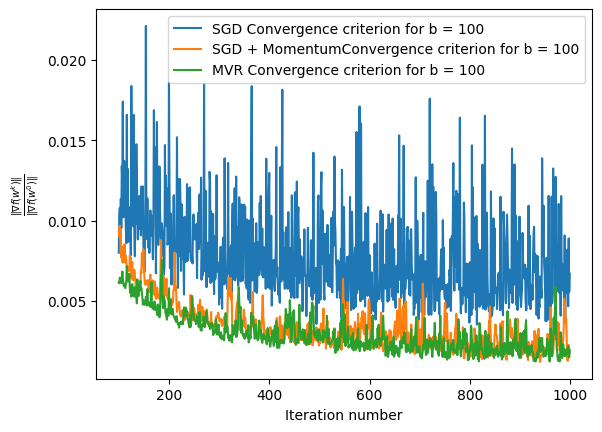

100%|██████████| 1000/1000 [03:21<00:00,  4.96it/s]


SGD implementation for batchsize 1000, took 203.22641801834106 seconds


100%|██████████| 1000/1000 [03:20<00:00,  4.99it/s]


SGD implementation with Momentum for batchsize 1000, beta 0.2, took 202.07565355300903 seconds


100%|██████████| 1000/1000 [06:38<00:00,  2.51it/s]

MVR SGD implementation for batchsize 1000, beta 0.2, took 399.43982577323914 seconds


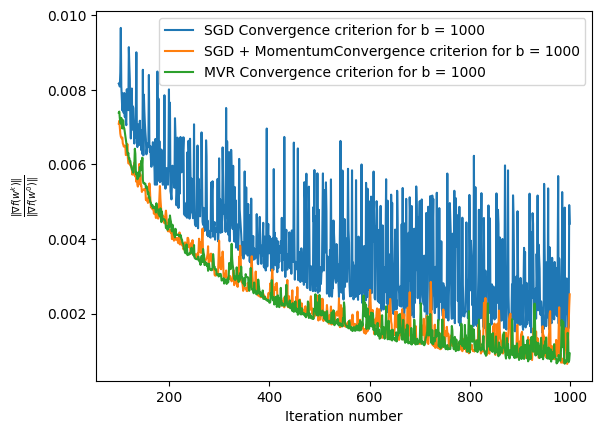

In [17]:
# zooming in
def tests(b = 10, gamma = lambda x: 1/L, beta = 0.2, K = 1000):
    w_0 = np.random.rand(X_train[0].shape[0])

    w_opt1, path1 = SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, b = b, K = K)
    x_cord1 = [i for i in range(len(path1))]
    plt.plot(x_cord1[100:], path1[100:], label = f'SGD Convergence criterion for b = {b}')
    plt.xlabel('Iteration number')
    plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
    # plt.legend()
    # plt.show()

    w_opt2, path2 = Momentum_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = K)
    x_cord2 = [i for i in range(len(path2))]
    plt.plot(x_cord2[100:], path2[100:], label = f'SGD + MomentumConvergence criterion for b = {b}')
    # plt.xlabel('Iteration number')
    # plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
    # plt.legend()
    # plt.show()

    w_opt3, path3 = MVR_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = K)
    x_cord3 = [i for i in range(len(path3))]
    plt.plot(x_cord3[100:], path3[100:], label = f'MVR Convergence criterion for b = {b}')
    # plt.xlabel('Iteration number')
    # plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
    plt.legend()
    plt.show()

batch_size = [1, 10, 100, 1000]
for b in batch_size:
    tests(b)

100%|██████████| 1000/1000 [00:00<00:00, 1558.52it/s]


SGD implementation for batchsize 1, took 2.1641204357147217 seconds


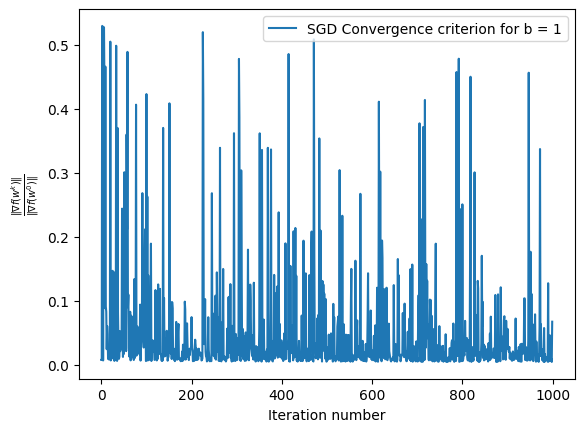

100%|██████████| 1000/1000 [00:00<00:00, 1711.38it/s]


SGD implementation with Momentum for batchsize 1, beta 0.2, took 2.1960432529449463 seconds


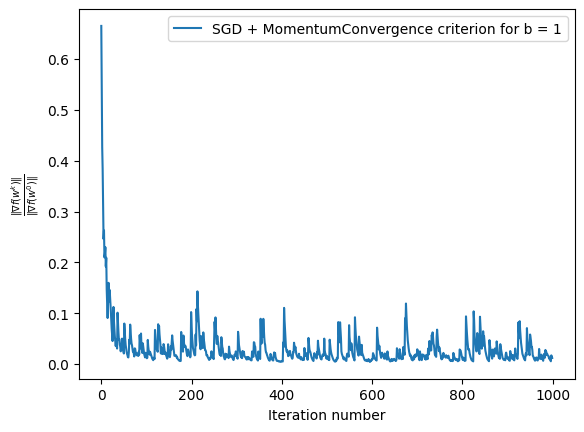

100%|██████████| 1000/1000 [00:01<00:00, 850.08it/s]


MVR SGD implementation for batchsize 1, beta 0.2, took 2.5372586250305176 seconds


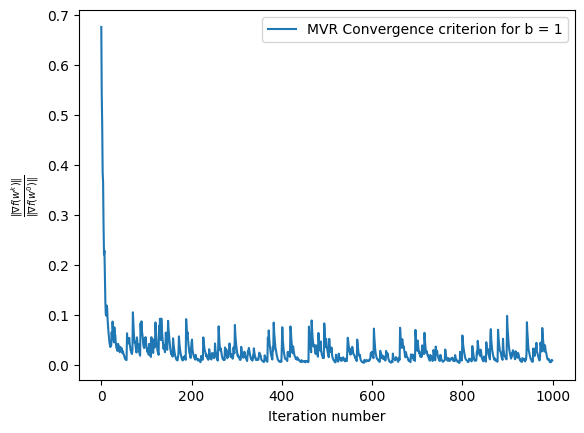

100%|██████████| 1000/1000 [00:02<00:00, 495.94it/s]


SGD implementation for batchsize 10, took 3.4487504959106445 seconds


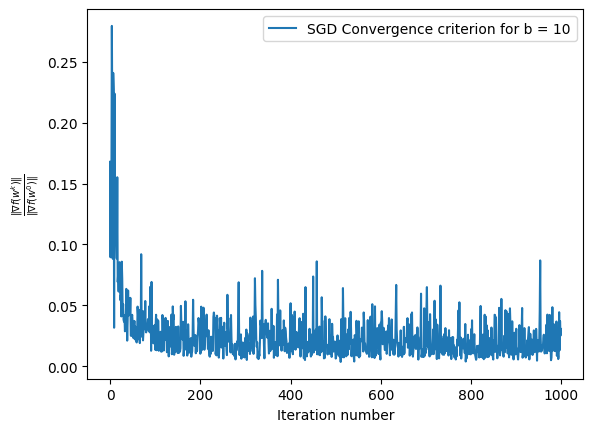

100%|██████████| 1000/1000 [00:02<00:00, 473.02it/s]


SGD implementation with Momentum for batchsize 10, beta 0.2, took 3.5337278842926025 seconds


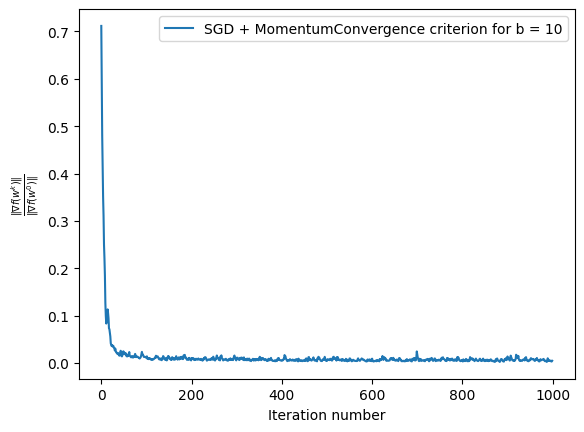

100%|██████████| 1000/1000 [00:04<00:00, 235.48it/s]


MVR SGD implementation for batchsize 10, beta 0.2, took 5.691504716873169 seconds


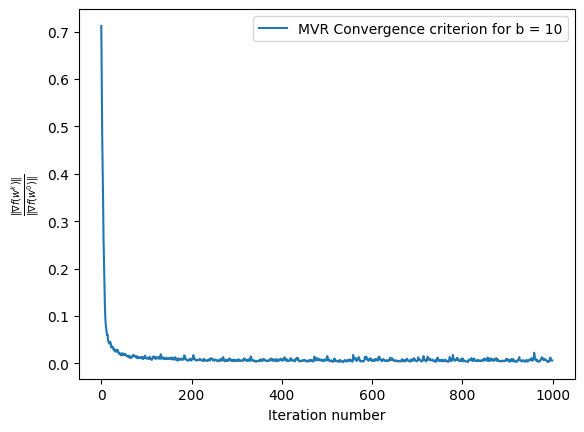

100%|██████████| 1000/1000 [00:19<00:00, 50.96it/s]


SGD implementation for batchsize 100, took 21.217347145080566 seconds


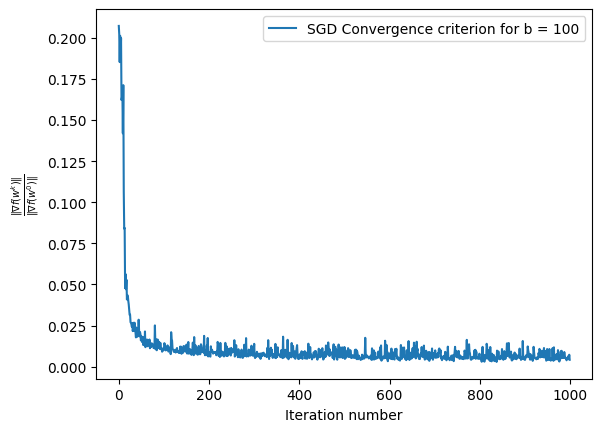

100%|██████████| 1000/1000 [00:20<00:00, 49.91it/s]


SGD implementation with Momentum for batchsize 100, beta 0.2, took 21.563734769821167 seconds


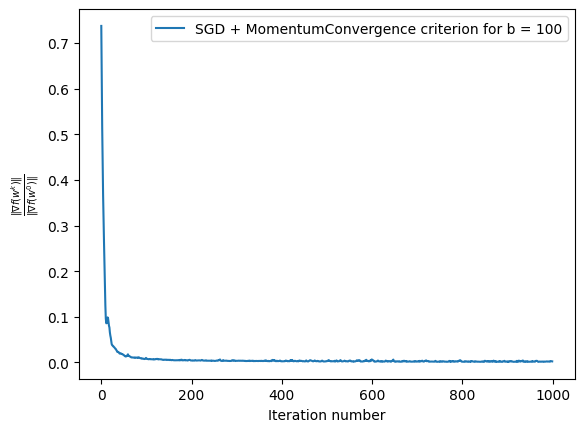

100%|██████████| 1000/1000 [00:39<00:00, 25.03it/s]


MVR SGD implementation for batchsize 100, beta 0.2, took 41.43016815185547 seconds


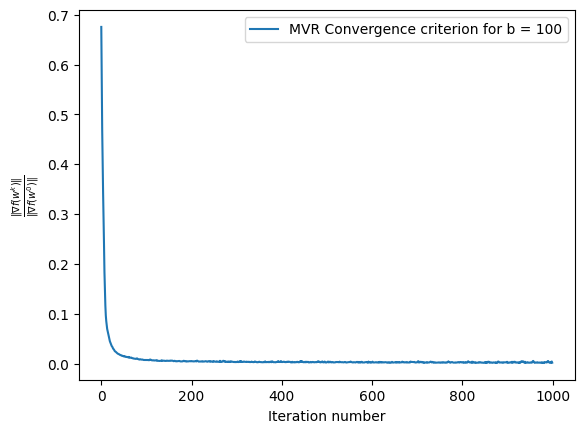

100%|██████████| 1000/1000 [03:18<00:00,  5.04it/s]


SGD implementation for batchsize 1000, took 199.9758005142212 seconds


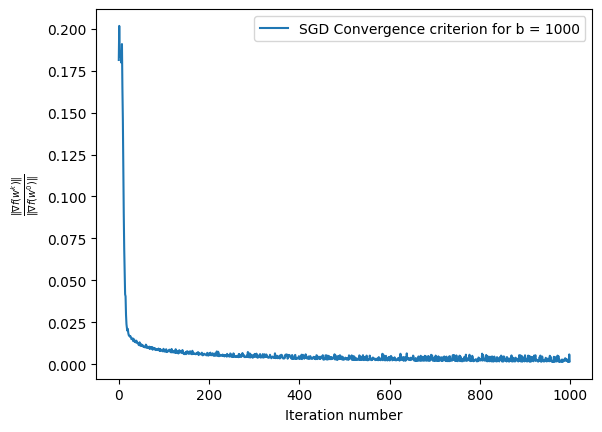

100%|██████████| 1000/1000 [03:19<00:00,  5.01it/s]

SGD implementation with Momentum for batchsize 1000, beta 0.2, took 201.0685818195343 seconds


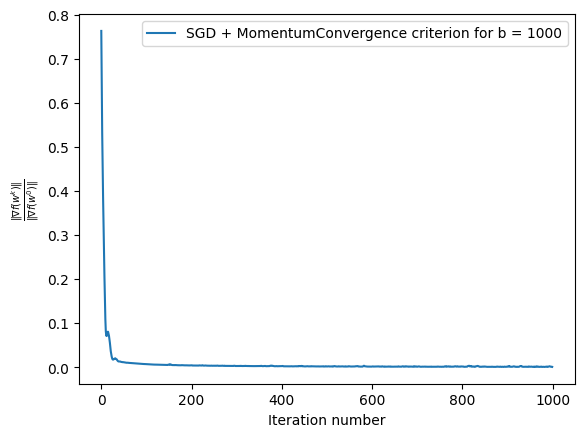

100%|██████████| 1000/1000 [06:37<00:00,  2.51it/s]


MVR SGD implementation for batchsize 1000, beta 0.2, took 399.28319454193115 seconds


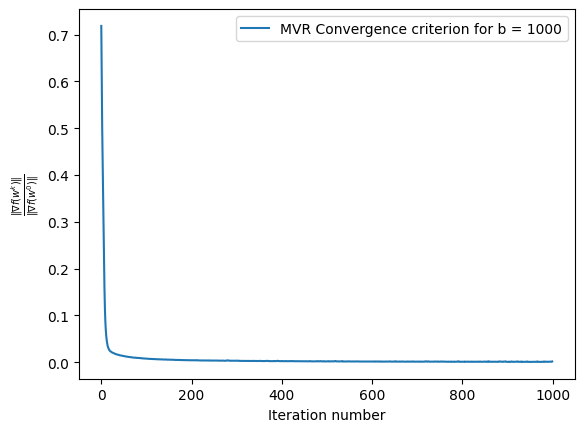

In [18]:
def tests(b = 10, gamma = lambda x: 1/L, beta = 0.2, K = 1000):
    w_0 = np.random.rand(X_train[0].shape[0])

    w_opt1, path1 = SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, b = b, K = K)
    x_cord1 = [i for i in range(len(path1))]
    plt.plot(x_cord1, path1, label = f'SGD Convergence criterion for b = {b}')
    plt.xlabel('Iteration number')
    plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
    plt.legend()
    plt.show()

    w_opt2, path2 = Momentum_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = K)
    x_cord2 = [i for i in range(len(path2))]
    plt.plot(x_cord2, path2, label = f'SGD + MomentumConvergence criterion for b = {b}')
    plt.xlabel('Iteration number')
    plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
    plt.legend()
    plt.show()

    w_opt3, path3 = MVR_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = K)
    x_cord3 = [i for i in range(len(path3))]
    plt.plot(x_cord3, path3, label = f'MVR Convergence criterion for b = {b}')
    plt.xlabel('Iteration number')
    plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
    plt.legend()
    plt.show()

batch_size = [1, 10, 100, 1000]
for b in batch_size:
    tests(b)

100%|██████████| 1000/1000 [00:00<00:00, 1603.93it/s]


SGD implementation for batchsize 1, took 2.137911081314087 seconds


100%|██████████| 1000/1000 [00:00<00:00, 1289.27it/s]


SGD implementation with Momentum for batchsize 1, beta 0.2, took 2.3110530376434326 seconds


100%|██████████| 1000/1000 [00:01<00:00, 801.24it/s]


MVR SGD implementation for batchsize 1, beta 0.2, took 2.6928136348724365 seconds


100%|██████████| 1000/1000 [00:02<00:00, 457.74it/s]


SGD implementation for batchsize 10, took 3.546227216720581 seconds


100%|██████████| 1000/1000 [00:02<00:00, 494.00it/s]


SGD implementation with Momentum for batchsize 10, beta 0.2, took 3.3475632667541504 seconds


100%|██████████| 1000/1000 [00:04<00:00, 236.28it/s]


MVR SGD implementation for batchsize 10, beta 0.2, took 5.606055736541748 seconds


100%|██████████| 1000/1000 [00:20<00:00, 49.99it/s]


SGD implementation for batchsize 100, took 21.503533601760864 seconds


100%|██████████| 1000/1000 [00:20<00:00, 49.49it/s]


SGD implementation with Momentum for batchsize 100, beta 0.2, took 21.618606567382812 seconds


100%|██████████| 1000/1000 [00:40<00:00, 24.73it/s]


MVR SGD implementation for batchsize 100, beta 0.2, took 41.99435210227966 seconds


100%|██████████| 1000/1000 [03:22<00:00,  4.93it/s]


SGD implementation for batchsize 1000, took 204.36102938652039 seconds


100%|██████████| 1000/1000 [03:25<00:00,  4.88it/s]


SGD implementation with Momentum for batchsize 1000, beta 0.2, took 206.59907746315002 seconds


100%|██████████| 1000/1000 [06:56<00:00,  2.40it/s]


MVR SGD implementation for batchsize 1000, beta 0.2, took 417.95491313934326 seconds


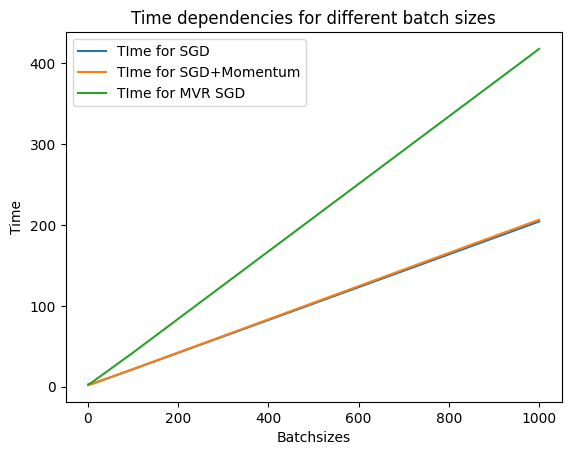

In [19]:
# test time/ oracle calls
SGD_time = []
Momentum_time = []
MVR_time = []
b = 10
gamma = lambda x: 1/L
beta = 0.2
K = 1000
for b in batch_size:
    start = time.time()
    SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, b = b, K = K)
    end = time.time()
    SGD_time.append(end-start)

    start = time.time()
    Momentum_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = K)
    end = time.time()
    Momentum_time.append(end-start)

    start = time.time()
    MVR_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = K)
    end = time.time()
    MVR_time.append(end-start)

plt.title('Time dependencies for different batch sizes')
plt.plot(batch_size, SGD_time, label = 'TIme for SGD')
plt.plot(batch_size, Momentum_time, label = 'TIme for SGD+Momentum')
plt.plot(batch_size, MVR_time, label = 'TIme for MVR SGD')
plt.xlabel('Batchsizes')
plt.ylabel('Time')
plt.legend()
plt.show()

For time dependencies, as earlier stated, SGD seems to be the fastest, followed by Momentum then MVR. But, in terms of noise of convergence, MVR has the lowest observed noise, followed by Momentum then SGD. Also, I observed direct proportion between batch sizes and variance as well as batch sizes and time.

100%|██████████| 1000/1000 [00:02<00:00, 489.79it/s]


SGD implementation for batchsize 10, took 3.5679855346679688 seconds


100%|██████████| 1000/1000 [00:02<00:00, 482.10it/s]


SGD implementation for batchsize 10, took 3.4328975677490234 seconds


100%|██████████| 1000/1000 [00:02<00:00, 401.33it/s]


SGD implementation for batchsize 10, took 3.9882235527038574 seconds


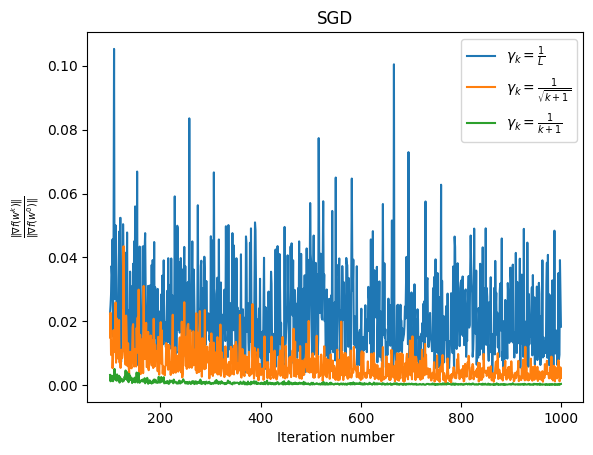

100%|██████████| 1000/1000 [00:02<00:00, 482.39it/s]


SGD implementation with Momentum for batchsize 10, beta 0.2, took 3.5266733169555664 seconds


100%|██████████| 1000/1000 [00:02<00:00, 467.63it/s]


SGD implementation with Momentum for batchsize 10, beta 0.2, took 3.6003735065460205 seconds


100%|██████████| 1000/1000 [00:02<00:00, 479.29it/s]


SGD implementation with Momentum for batchsize 10, beta 0.2, took 3.522141933441162 seconds


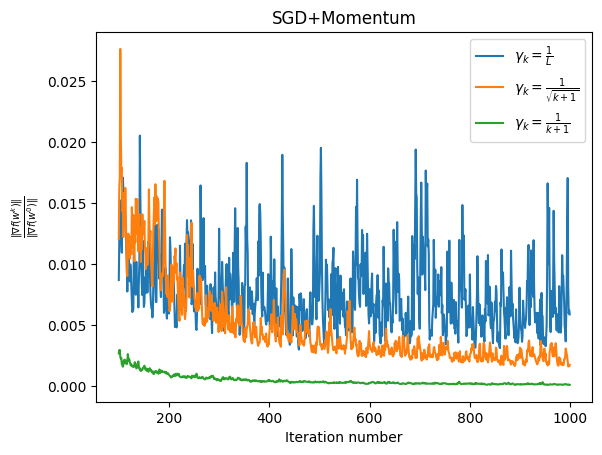

100%|██████████| 1000/1000 [00:04<00:00, 249.45it/s]


MVR SGD implementation for batchsize 10, beta 0.2, took 5.413435935974121 seconds


100%|██████████| 1000/1000 [00:04<00:00, 239.72it/s]


MVR SGD implementation for batchsize 10, beta 0.2, took 5.721343040466309 seconds


100%|██████████| 1000/1000 [00:04<00:00, 239.42it/s]


MVR SGD implementation for batchsize 10, beta 0.2, took 5.484902620315552 seconds


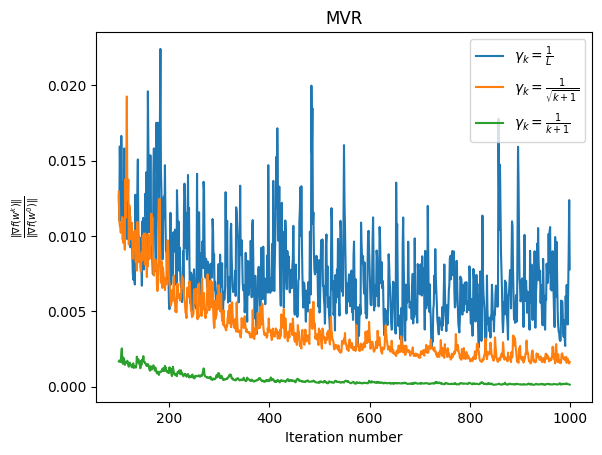

In [20]:
gamma_1 = lambda x: 1/L
gamma_2 = lambda x: 1/np.sqrt(x+1)
gamma_3 = lambda x: 1/(x+1)

gamma_k = [gamma_1, gamma_2, gamma_3]
titles = ['$\\gamma_k = \\frac{1}{L}$','$\\gamma_k = \\frac{1}{\\sqrt{k+1}}$' , '$\\gamma_k = \\frac{1}{k+1}$']

w_0 = np.random.rand(X_train[0].shape[0])
b = 10
beta = 0.2
K = 1000
for i in range(3):
    gamma = gamma_k[i]
    title = titles[i]

    w_opt1, path1 = SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, b = b, K = K)
    x_cord1 = [i for i in range(len(path1))]
    plt.plot(x_cord1[100:], path1[100:], label = title)

plt.title('SGD')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

for i in range(3):
    gamma = gamma_k[i]
    title = titles[i]

    w_opt1, path1 = Momentum_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = K)
    x_cord1 = [i for i in range(len(path1))]
    plt.plot(x_cord1[100:], path1[100:], label = title)

plt.title('SGD+Momentum')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

for i in range(3):
    gamma = gamma_k[i]
    title = titles[i]

    w_opt1, path1 = MVR_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = K)
    x_cord1 = [i for i in range(len(path1))]
    plt.plot(x_cord1[100:], path1[100:], label = title)

plt.title('MVR')
plt.xlabel('Iteration number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^k) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.legend()
plt.show()

From the plots, we can see that convergence is fastest for $\frac{1}{k+1}$, followed by $\frac{1}{\sqrt{k+1}}$, before $\frac{1}{L}$, similarly, variance is least for $\frac{1}{k+1}$, followed by $\frac{1}{\sqrt{k+1}}$, before $\frac{1}{L}$. This suggests that the Lipschitz-constant for the gradient is lower than $L$.

_(1.4 points + 2 bonus points)_

Now, decide what type of plots do you want to analyse:
- Accuracy (as from the first assignment)
- Same criteria as from the previous point

Using the selected type of plots, try to understand, how the `momentum parameter` influences on the behaviour of convergence `for SGD+momentum & MVR only`.  

The ideas for search:
- $b = 0.1$ is proposed as working well for many algorithms. You can propose to plot the relative characteristics of convergency rate
- Take the logarithmically scaled range of $b$ and plot the reached criteria after *fixed amount of iterations* for both methods from the $b$

***1.4 points*** for the basic idea reproduction:
- visualise plots from the previous point (changing $\text{batch\_size}$ and $\gamma_k$, without a second plot with oracle calls/time) for somehow seleceted $b$'s.
- make the conclusions

***up to 2 bonus points***: for the interesting ideas of visualisation (you can choose one from the proposed), for the justified procedure of momentum selection (maybe, found in the article - then provide it), for any kind of additional conclusions

100%|██████████| 20/20 [00:00<00:00, 432.11it/s]


SGD implementation with Momentum for batchsize 10, beta 0.01, took 1.578819751739502 seconds


100%|██████████| 20/20 [00:00<00:00, 274.52it/s]


MVR SGD implementation for batchsize 10, beta 0.01, took 1.565075159072876 seconds


100%|██████████| 20/20 [00:00<00:00, 449.28it/s]


SGD implementation with Momentum for batchsize 10, beta 0.01668100537200059, took 1.4905304908752441 seconds


100%|██████████| 20/20 [00:00<00:00, 253.21it/s]


MVR SGD implementation for batchsize 10, beta 0.01668100537200059, took 1.5747840404510498 seconds


100%|██████████| 20/20 [00:00<00:00, 615.25it/s]


SGD implementation with Momentum for batchsize 10, beta 0.027825594022071243, took 1.379223346710205 seconds


100%|██████████| 20/20 [00:00<00:00, 273.92it/s]


MVR SGD implementation for batchsize 10, beta 0.027825594022071243, took 1.5133659839630127 seconds


100%|██████████| 20/20 [00:00<00:00, 379.19it/s]


SGD implementation with Momentum for batchsize 10, beta 0.04641588833612779, took 1.522190809249878 seconds


100%|██████████| 20/20 [00:00<00:00, 286.92it/s]


MVR SGD implementation for batchsize 10, beta 0.04641588833612779, took 1.4044291973114014 seconds


100%|██████████| 20/20 [00:00<00:00, 460.77it/s]


SGD implementation with Momentum for batchsize 10, beta 0.0774263682681127, took 1.3867316246032715 seconds


100%|██████████| 20/20 [00:00<00:00, 216.23it/s]


MVR SGD implementation for batchsize 10, beta 0.0774263682681127, took 1.467250108718872 seconds


100%|██████████| 20/20 [00:00<00:00, 484.60it/s]


SGD implementation with Momentum for batchsize 10, beta 0.12915496650148842, took 1.7521917819976807 seconds


100%|██████████| 20/20 [00:00<00:00, 243.38it/s]


MVR SGD implementation for batchsize 10, beta 0.12915496650148842, took 1.5878171920776367 seconds


100%|██████████| 20/20 [00:00<00:00, 594.05it/s]


SGD implementation with Momentum for batchsize 10, beta 0.21544346900318834, took 1.456084966659546 seconds


100%|██████████| 20/20 [00:00<00:00, 221.18it/s]


MVR SGD implementation for batchsize 10, beta 0.21544346900318834, took 1.5585689544677734 seconds


100%|██████████| 20/20 [00:00<00:00, 389.37it/s]


SGD implementation with Momentum for batchsize 10, beta 0.3593813663804626, took 1.410639762878418 seconds


100%|██████████| 20/20 [00:00<00:00, 294.98it/s]


MVR SGD implementation for batchsize 10, beta 0.3593813663804626, took 1.3510727882385254 seconds


100%|██████████| 20/20 [00:00<00:00, 474.46it/s]


SGD implementation with Momentum for batchsize 10, beta 0.5994842503189408, took 1.499800443649292 seconds


100%|██████████| 20/20 [00:00<00:00, 258.58it/s]


MVR SGD implementation for batchsize 10, beta 0.5994842503189408, took 1.5283503532409668 seconds


100%|██████████| 20/20 [00:00<00:00, 476.45it/s]


SGD implementation with Momentum for batchsize 10, beta 1.0, took 1.5397982597351074 seconds


100%|██████████| 20/20 [00:00<00:00, 322.89it/s]


MVR SGD implementation for batchsize 10, beta 1.0, took 1.6168534755706787 seconds


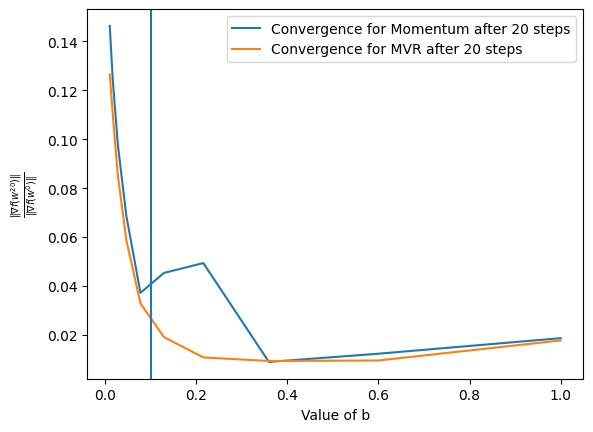

In [21]:
# JUST DO IT! It will be breathtaking :)
# your solution here
betas = np.logspace(-1, 1, 10)
betas = betas/10
Momentum_convergence = []
MVR_convergence = []

for beta in betas:
    # Take convergence after 20 iterations
    w_opt2, path2 = Momentum_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = 20)
    Momentum_convergence.append(path2[-1])

    w_opt3, path3 = MVR_SGD(nabla_f = gradient, w_0 = w_0, gamma = gamma, beta = beta, b = b, K = 20)
    MVR_convergence.append(path3[-1])


plt.plot(betas, Momentum_convergence, label = 'Convergence for Momentum after 20 steps')
plt.plot(betas, MVR_convergence, label = 'Convergence for MVR after 20 steps')
plt.xlabel('Value of b')
plt.ylabel('$ \\frac{\\| \\nabla f (w^{20}) \\|}{\\| \\nabla f (w^0)\\|} $')
plt.axvline(x=0.1)
plt.legend()
plt.show()

We can observe the elbow effect after $b=0.1$ Thus suggesting that the optimal value is somewhere around there.

### Solving the distributed optimization problem

**AGAIN ...**

Consider again the empirical risk minimization:
\begin{equation}
\min_{w \in \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i) + \frac{\lambda}{2} \| w\|^2_2,
\end{equation}
where $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ is a loss function, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ is a model, $w$ are parameters of the model, $\{x_i, y_i\}_{i=1}^n$ is data of objects $x_i \in \mathbb{R}^x$ and labels $y_i \in \mathbb{R}$.

We use the linear model $g(w, x) = w^T x$ and the logistic/sigmoid loss function: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Important: $y$ must take values $-1$ or $1$__). As we already know, the resulting problem is called a logistic regression problem.

This problem can be rewritten as follows:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{s} \sum\limits_{j=1}^s f_j(w) := \frac{1}{s} \sum\limits_{j=1}^s \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_{(j-1)b + i}), y_{(j-1)b + i}) + \frac{\lambda}{2} \| w\|^2_2\right],
\end{equation}
where $b$ is the local data size, $s$ is the number of devices, and $b s = n$ is the total sample size.

The gradient of $f_j$:
$$
\nabla f_j(w) = \frac{1}{b} \sum_{i=1}^b \frac{-y_{(j-1)b + i} x_{(j-1)b + i}}{1 + \exp(y_{(j-1)b + i} w^Tx_{(j-1)b + i})} + \lambda w.
$$
The Lipschitz constant of the gradient $\nabla f_j$ can be estimated as $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2 + \lambda$.

Let us do some preparation work. The _mushrooms_ dataset is attached. Use the following code to generate a matrix $X$ and vector $y$, which will store the sample $\{x_i, y_i\}_{i=1}^n$:

In [22]:
dataset = "mushrooms.txt" # '/content/mushrooms.txt'
#the file must be in the same directory as notebook.

In [23]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

Let us change the vector $y$ so that $y_i$ takes values $-1$ and $1$. You can also do additional preprocessing of the data (with techniques from machine learning), but this is not additionally assessed in any way.

In [24]:
y = 2 * y - 3

Let us divide the data into two parts: training and test.

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For the training part $X_{train}$, $y_{train}$, estimate the constant $L$. Set $\lambda$ such that $\lambda \approx L / 1000$.  Realize in the code the calculation of the value and gradient for our target function ($X$, $y$, $\lambda$ should be given as a parameter so that it is possible to change them, not only to substitute fixed $X_{train}$, $y_{train}$). You can use ``numpy``, or ``autograd``, ``pytorch``, ``jax``.

Consider a given batch, $X_{b, j}$
Then, $L_j = \frac{1}{4b} \sum\limits_{i=1}^b \| x_{(j-1)b + i} \|^2_2 = \frac{1}{4b} \sum\limits_{i=1}^b x_{(j-1)b + i}^Tx_{(j-1)b + i} = \frac{1}{4b}\text{trace}(X_{b, j}^TX_{b, j})$

In [26]:
#your solution (Code and Markdown)

import numpy as np
# To estimate L from train sets
L = np.trace(X_train.T @ X_train)/(4*X_train.shape[0])

regularizer = L/1000 # lambda

def L_estimate(batch = X_train):
    return np.trace(batch.T @ batch)/(4*batch.shape[0])

def cost(w, x, y, regularizer = regularizer):
    '''
    Evaluates the cost function

    Parameters
    w:           numpy array containing weights of the model
    x:           numpy array containing features of the data point
    y:           numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    loss: the value of the cost function of a data batch for a given set of weights
    '''
    n = len(y)
    loss = 0
    g = (x @ w).flatten()
    y = y.flatten()
    for i in range(n):
        l = np.log(1 + np.exp(-y[i]*g[i]))
        loss += l
    loss /= n
    loss += regularizer * np.sum(w.T @ w)
    return loss

import autograd
import autograd.numpy as anp

def cost1(w, x, y, regularizer = regularizer):
    '''
    Evaluates the cost function

    Parameters
    w:           autograd.numpy array containing weights of the model
    x:           autograd.numpy array containing features of the data point
    y:           autograd.numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    loss: the value of the cost function of a data batch for a given set of weights
    '''
    n = len(y)
    loss = 0
    g = (x @ w).flatten()
    y = y.flatten()
    for i in range(n):
        l = anp.log(1 + anp.exp(-y[i]*g[i]))
        loss += l
    loss /= n
    loss += regularizer * anp.sum(w.T @ w)
    return loss

formula = False
def gradient(w, x, y, formula = formula, regularizer = regularizer):
    '''
    Evaluates the gradient function

    Parameters
    w:           numpy array containing weights of the model
    x:           numpy array containing features of the data point
    y:           numpy array containing class labels for each data point
    regularizer: user defined parameter for regularising

    Returns:
    grad: the value of the gradient function of a data batch for a given set of weights
    '''
    # def dfdx_i(f: callable,
    #            x: np.ndarray,
    #            i=0,
    #            eps=1e-3
    #           ):
    #     out = np.zeros_like(x)
    #     out[i] = eps
    #     return (f(x + out) - f(x - out))/2/eps

    f = lambda w: cost1(w, x, y)
    if formula:
        g = (x @ w).flatten()
        grad = np.zeros_like(x[0])
        for i in range(len(y)):
            denominator = 1 + np.exp(y[i] * g[i])
            numerator = - y[i] * x[i]
            grad += numerator / denominator
        grad += regularizer * w              # Similar mistake with previous HW, so I added the missing lambda
        return grad
    else:
        # grad = [dfdx_i(f, np.zeros_like(x[0]), i) for i in range(len(x[0]))]  Too slow
        # grad += regularizer * w
        return autograd.grad(f)(w)                                            # Faster


__Problem 0. (2 + bonus 4  points)__ Since we have to deal with a distributed setting, we need to be able to divide the data into parts. The basic variant of this you have most likely already realized in the previous assignment when dividing data into batches.

In [ ]:
#your solution (Code and Markdown)

def split_data(b: int, data: tuple[np.array] = (X_train, y_train)) -> tuple:
    '''
    Parameters:
    b: Batchsizes of each data
    data: Tuple of numpy arrays

    Returns:
    out: tuple of tuples of numpy arrays
    '''
    out = []
    for i in range(0, len(data[1]), b):
        out.append((data[0][i: i+b], data[1][i: i+b]))
    return tuple(out)

But for more interesting results, additional features can be implemented:

__a). (2 points)__ Divide the data non-uniformly/heterogeneously, e.g., give some of the devices predominantly data with labels equal to $1$ and others with $- 1$. You can use this example, or you can figure out your own way how to split the data heterogeneously. In any case, describe your approach and implement it. Ideally, you should be able to vary the degree of heterogeneity from "uniformly" to "absolutely different" splits.

In [28]:
#your solution (Code and Markdown)
import random

def split_data_heterogeneously(heterogeneity, b: int, data: tuple[np.array] = (X_train, y_train)):
    '''
    Parameters:
    heterogeneity: Measure of heterogeneousness for the data split [0, 1], 1 for full heterogeneity
    b            : Batchsizes of each data
    data         : Tuple of numpy arrays

    Returns:
    out          : list of tuples of numpy arrays
    '''
    assert heterogeneity <= 1
    assert heterogeneity >= 0
    pos1 = [[], []] # get features with labels +1 with possible mixing
    neg1 = [[], []] # get features with labels -1 with possible mixing
    X_train = data[0]
    y_train = data[1]
    for i in range(len(y_train)):
        if (y_train[i] > 0):
            if random.uniform(-1, 1) < heterogeneity: # The probability that it is heterogeneous
                                                      # If the heterogeneity is set to 0, it becomes totally random
                pos1[0].append(X_train[i])
                pos1[1].append(y_train[i])
            else:
                neg1[0].append(X_train[i])
                neg1[1].append(y_train[i])
        else:
            if random.uniform(0, 1) < heterogeneity:
                neg1[0].append(X_train[i])
                neg1[1].append(y_train[i])
            else:
                pos1[0].append(X_train[i])
                pos1[1].append(y_train[i])
    datapos = tuple(pos1)
    dataneg = tuple(neg1)
    out = list(split_data(b, datapos)) + list(split_data(b, dataneg))
    return tuple(out)

In [29]:
out1 = split_data_heterogeneously(heterogeneity = 1, b = 100)
print('Observe high heterogeneity')
print(out1[40][1])
print(sum(out1[40][1]))
out2 = split_data_heterogeneously(heterogeneity = 0, b = 100)
print('Observe low heterogeneity')
print(out2[40][1])
print(sum(out2[40][1]))

Observe high heterogeneity
[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]
-100.0
Observe low heterogeneity
[1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.

Sums with high absolute values, relative to batch size, indicate high heterogeneity of the split.

Distributed computing can be sufficiently simulated on a single device. Absolutely enough, if you do it in the dumbest way with an additional loop.

__b). (bonus 4 points)__ But you can plug in some specialized libraries. For example, ``ray`` library, but you can also use other approaches. Describe what you are going to do. We advise you to make this point if you understand that you have enough time and resources to organize distributed computing.

In [64]:
! pip install --upgrade pip

  Using cached pip-24.3.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-24.3.1-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Python311\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:
#your solution (Code and Markdown)

! pip install ray

import ray
ray.init()


  Using cached ray-2.40.0-cp311-cp311-win_amd64.whl.metadata (18 kB)
Using cached ray-2.40.0-cp311-cp311-win_amd64.whl (25.2 MB)


ERROR: Could not install packages due to an OSError: [WinError 2] Не удается найти указанный файл: 'C:\\Python311\\Scripts\\ray.exe' -> 'C:\\Python311\\Scripts\\ray.exe.deleteme'


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-05 12:53:16,636	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-05 12:53:23,640	INFO worker.py:1821 -- Started a local Ray instance.


Python version:,3.11.5
Ray version:,2.40.0


In [ ]:
#your solution (Code and Markdown)

@ray.remote
def worker(w, batch):
    '''
    w      : Gradient from Server
    batch  : Data available to worker
    
    Returns:
    Local Gradient Value
    '''
    x = np.array(batch[0])
    y = np.array(batch[1])
    g = (x @ w).flatten()
    grad = np.zeros_like(x[0])
    for i in range(len(y)):
        denominator = 1 + np.exp(y[i] * g[i])
        numerator = - y[i] * x[i]
        grad += numerator / denominator
    grad += regularizer * w
    L = np.trace(x.T @ x)/(4 * x.shape[0])
    return w -  grad/L

def Distributed_GD(nabla_f, w_0, hetero = 0, num_parts = 10,
        K = 100, eps = 1e-2, data = (X_train, y_train)):
    '''
    Finds the zero of nabla_f using stochastic gradient descent with compression

    Parameters
    nabla_f    :   Gradient of the cost function
    w_0        :   Start point
    hetero     :   Heterogeinty of the data_split [0, 1]
    num_parts  :   Number of independent batches to split the data into
    K          :   Number if iterations
    eps        :   Accuracy
    data       :   Data to train the algorithm on

    Return
    w_opt   :   Optimal point found by the algorithm
    path    :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]
    testacc :   Prediction accuracy per iteration on test set
    trainacc:   Prediction accuracy per iteration on train set
    '''
    start = time.time()
    b = len(data[0])//num_parts
    batches =  split_data_heterogeneously(hetero, b, data)
    batches = tuple(list(batches[:num_parts])) # To have the number of parts equal to the number of workers
    
    print(len(batches))

    w_prev = w_0
    C = np.linalg.norm(nabla_f(w_0, data[0], data[1]))
    path = []
    testacc = []
    trainacc = []
    w_new = np.zeros_like(w_prev)
    
    for _ in tqdm(range(K)):
        
        obj_ref = [worker.remote(w_prev, batch) for batch in batches]
        # Update weights
        obj = ray.get(obj_ref)
        # print(obj)
        w_new = np.array(sum(obj))
        w_new /= num_parts

        path.append(np.linalg.norm(w_new - w_prev)/C)
        testacc.append(sum(predict(w_new, X_test) == y_test)/len(y_test))
        trainacc.append(sum(predict(w_new, X_train) == y_train)/len(y_train))
        if np.all(np.abs(w_new - w_prev) <= eps):
            break
        
        # Broadcast new weights to all nodes
        w_prev = w_new
    
    w_opt = w_new
    end = time.time()
    print(f'Distributed GD implementation for {num_parts} workers, took {end - start} seconds')
    return w_opt, path, testacc, trainacc

10


100%|██████████| 100/100 [00:10<00:00,  9.96it/s]


Distributed GD implementation for 10 workers, took 11.31758189201355 seconds


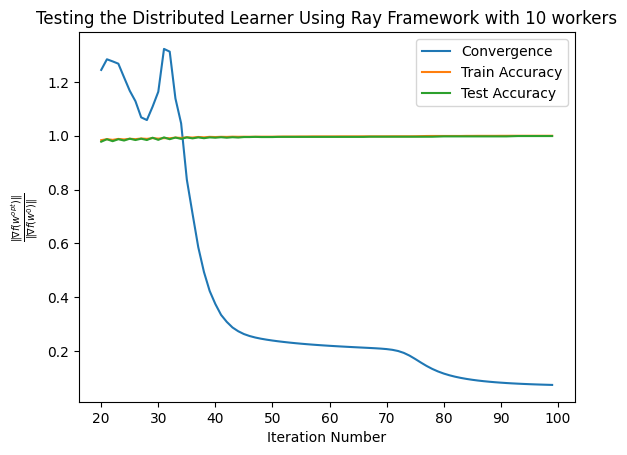

In [91]:
nabla_f = gradient
w_0 = np.random.rand(X_train[0].shape[0])


w_opt, path, testacc, trainacc = Distributed_GD(nabla_f, w_0)
xs = [i for i in range(len(path))]
plt.title('Testing the Distributed Learner Using Ray Framework with 10 workers')
plt.plot(xs[20:], path[20:], label = 'Convergence')
plt.plot(xs[20:], trainacc[20:], label = 'Train Accuracy')
plt.plot(xs[20:], testacc[20:], label = 'Test Accuracy')
plt.xlabel('Iteration Number')
plt.ylabel('$ \\frac{\\| \\nabla f (w^{opt}) \\|}{\\| \\nabla f (w^0)\\|}$')
plt.legend()
plt.show()

In [92]:
formula = True
SGD(nabla_f, w_0, gamma, b = len(y_train)//10)
formula = False

100%|██████████| 1000/1000 [01:53<00:00,  8.82it/s]

SGD implementation for batchsize 649, took 114.41277861595154 seconds


**Distributed vs Non Distributed**

Comparing the Distributed Set Up to the Non Distributed set up with similar batch size per worker, using formula for gradient descent, we can see there very serious improvement in Time taken.

Distributed Set Up took about 11 seconds

Non Distributed Set Up took about 114 seconds

__Problem 1. (12 points)__ This part of the assignment is related to __distributed with compression__ methods.

__а). (2 points)__ Implement the $\text{Rand}k$ and $\text{Top}k$ compression operators, where $k$ is a parameter.

In [59]:
#your solution (Code)


# w = d/k - 1

def RandK(k, x):
    '''
    Parameters:
    k           : The percentage of coordinates sent
    x           : A numpy array to be compressed

    Returns:
    x_compressed: A numpy array that has been compressed
    mask        : Compressor mask showing coordinates transmitted
    '''
    assert k <= 100
    assert k > 0

    d = len(x)
    k = int(d*k/100)
    C_i = np.zeros(d)
    C_i[:k] =  1
    np.random.shuffle(C_i)
    mask = C_i > 0
    x_compressed = (d/k) * C_i * x
    return x_compressed, mask

def TopK(k, x):
    '''
    Parameters:
    k           : The percentage of compression
    x           : A numpy array to be compressed

    Returns:
    x_compressed: A numpy array that has been compressed
    C_i         : Compressor mask showing coordinates transmitted
    '''
    assert k <= 100
    assert k >= 0
    d = len(x)
    k = int(d*k/100)
    C_i = np.zeros(d)
    x_abs = np.abs(x)
    x_abs.sort()
    check = x_abs[-k-1]  # Check for the value they must all be greater than
    C_i = np.abs(x) > check
    x_compressed = C_i * x
    return x_compressed, C_i

__b). (3 points)__ Simulate a distributed  environment with $s=10$ parts and uniformly distributed data. Implement simple distributed gradient descent with compression operators. Compress information only from the devices to the server. Use compression operators $\text{Rand}1\%$, $\text{Rand}5\%$, $\text{Rand}10\%$, $\text{Rand}20\%$. Use steps are equal to $L^{-1} (\frac{2 \omega}{s} + 1)^{-1}$ (theoretical). Explain what is $L$ and $\omega$ here.

Draw the comparison plots for different operators: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [93]:
#your solution (Code and Markdown)
def gamma_CGD(batch, w, s):
    L = L_estimate(batch)
    return 1/(L * (2*w/s + 1))


def CGD(nabla_f, w_0, compressor, k, hetero = 0, gamma = None, num_parts = 10,
        K = 100, eps = 1e-6, data = (X_train, y_train)):
    '''
    Finds the zero of nabla_f using stochastic gradient descent with compression

    Parameters
    nabla_f    :   Gradient of the cost function
    w_0        :   Start point
    compressor :   Compression operator
    k          :   Parameter for compressor
    hetero     :   Heterogeinty of the data_split [0, 1]
    gamma      :   Step Method
    num_parts  :   Number of independent batches to split the data into
    K          :   Number if iterations
    eps        :   Accuracy
    data       :   Data to train the algorithm on

    Return
    w_opt   :   Optimal point found by the algorithm
    path    :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]
    num_trn :   Number of transmitted coordinates per iteration
    testacc :   Prediction accuracy per iteration on test set
    trainacc:   Prediction accuracy per iteration on train set
    '''
    start = time.time()
    b = len(data[0])//num_parts
    batches =  split_data_heterogeneously(hetero, b, data)
    batches = batches[:num_parts]

    w_prev = w_0
    C = np.linalg.norm(nabla_f(w_0, data[0], data[1]))
    path = []
    num_trn = []
    testacc = []
    trainacc = []
    d = len(w_0)
    w = d/int(d*k/100) - 1
    s = num_parts
    w_new = np.zeros_like(w_prev)
    mask = np.zeros_like(w_prev) # Set to False
    if not gamma:
        gamma = lambda x: gamma_CGD(x, w, s)
        for _ in tqdm(range(K)):
            for i in range(num_parts):
                batch = batches[i]  # Worker i has access to batch i
                grad_comp, m = compressor(k, nabla_f(w_prev, np.array(batch[0]), np.array(batch[1])))
                w_new += w_prev - gamma(np.array(batch[0])) * grad_comp # Compress and send to server
                mask += m # Get coordinates transmitted
            # Update weights
            w_new /= num_parts

            path.append(np.linalg.norm(w_new - w_prev)/C)
            num_trn.append(sum(mask > 0))
            testacc.append(sum(predict(w_new, X_test) == y_test)/len(y_test))
            trainacc.append(sum(predict(w_new, X_train) == y_train)/len(y_train))
            #if np.all(100000*np.abs(w_new - w_prev) <= eps):
                #break
            # Broadcast new weights to all nodes
            w_prev = w_new
    else:
        for i in tqdm(range(K)):
            for j in range(num_parts):
                batch = batches[j] # Worker j has access to batch j
                grad_comp, m = compressor(k, nabla_f(w_prev, np.array(batch[0]), np.array(batch[1])))
                w_new += w_prev - gamma(i) * grad_comp # Compress and send to server
                mask += m # Get coordiinates transmitted
            # Update weights
            w_new /= num_parts

            path.append(np.linalg.norm(w_new - w_prev)/C)
            num_trn.append(sum(mask > 0))
            testacc.append(sum(predict(w_new, X_test) == y_test)/len(y_test))
            trainacc.append(sum(predict(w_new, X_train) == y_train)/len(y_train))
            #if np.all(100000*np.abs(w_new - w_prev) <= eps):
                #break
            # Broadcast new weights to all nodes
            w_prev = w_new
    w_opt = w_new
    end = time.time()
    print(f'CGD implementation for batchsize {b}, took {end - start} seconds')
    return w_opt, path, num_trn, testacc, trainacc

$\omega$ is some sort of bound on how much the variance is scaled after compression, while $L$ is the estimate of the Lipschitz-constant of the gradient function.

In [94]:
sum(predict(w_opt1, X_train) == y_train)/len(y_train)

0.8396676411755655

  2%|▏         | 2/100 [00:02<02:12,  1.36s/it]c:\Python311\Lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
c:\Python311\Lib\site-packages\autograd\numpy\numpy_vjps.py:74: RuntimeWarning: invalid value encountered in scalar multiply
  defvjp(anp.exp,    lambda ans, x : lambda g: ans * g)
100%|██████████| 100/100 [02:36<00:00,  1.57s/it]


CGD implementation for batchsize 649, took 158.65857124328613 seconds


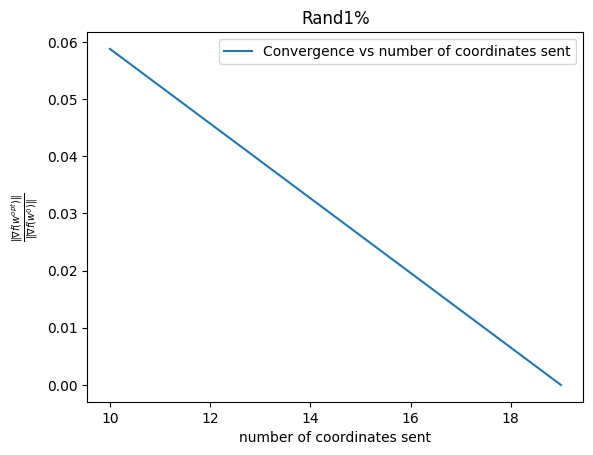

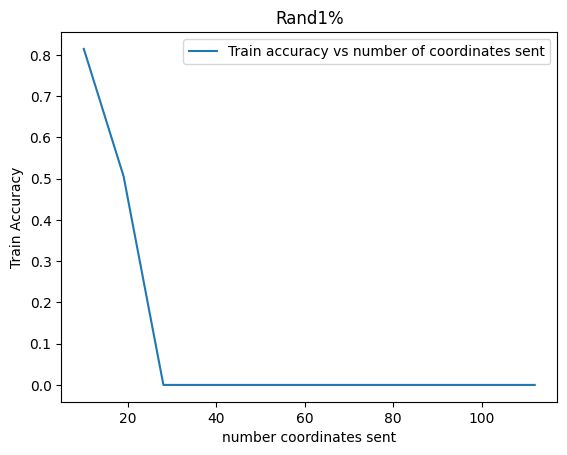

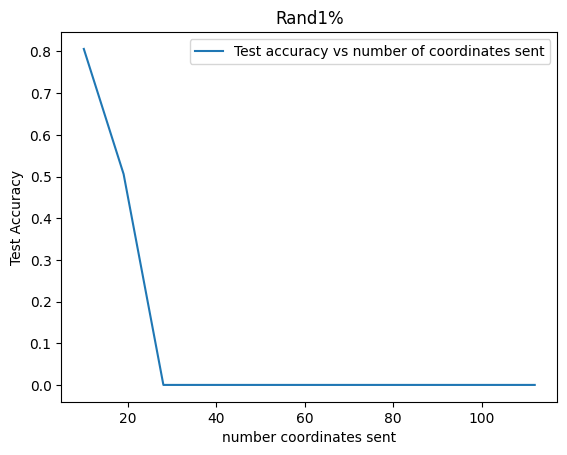

100%|██████████| 100/100 [02:40<00:00,  1.60s/it]


CGD implementation for batchsize 649, took 161.87248706817627 seconds


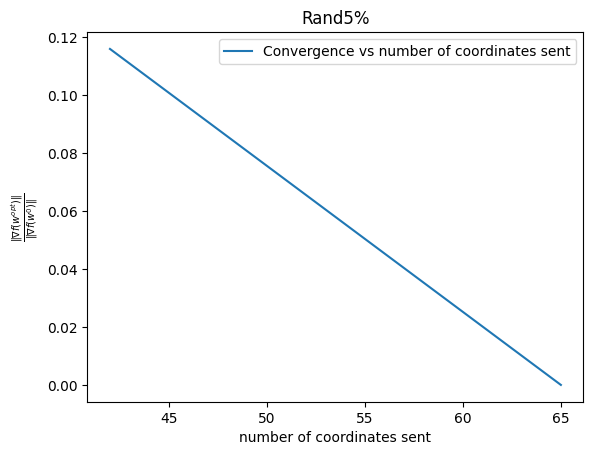

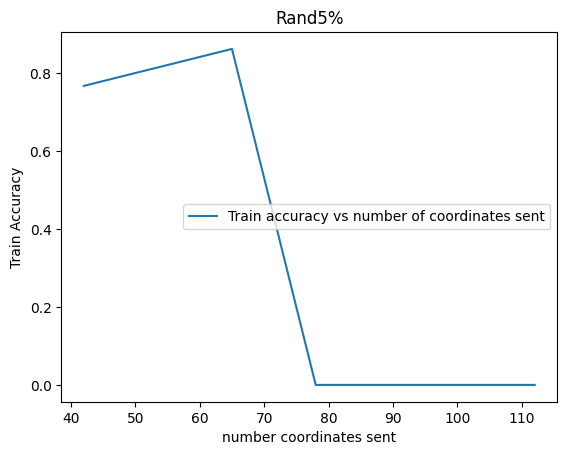

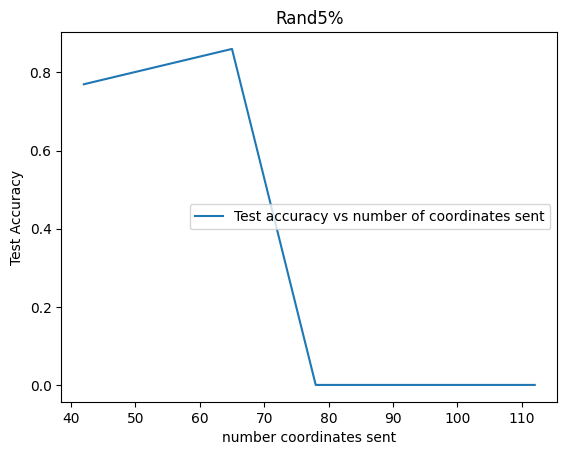

100%|██████████| 100/100 [02:17<00:00,  1.38s/it]


CGD implementation for batchsize 649, took 139.2216067314148 seconds


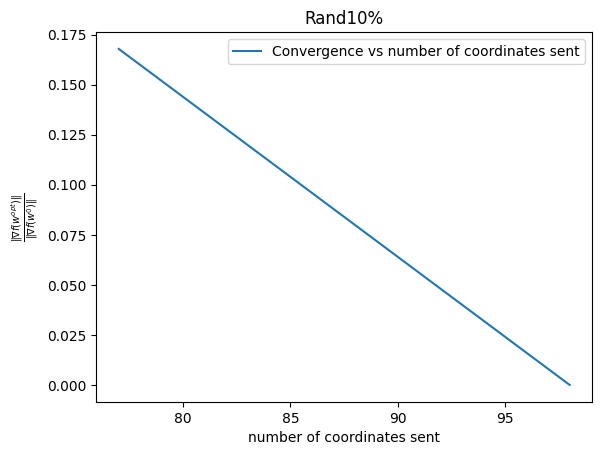

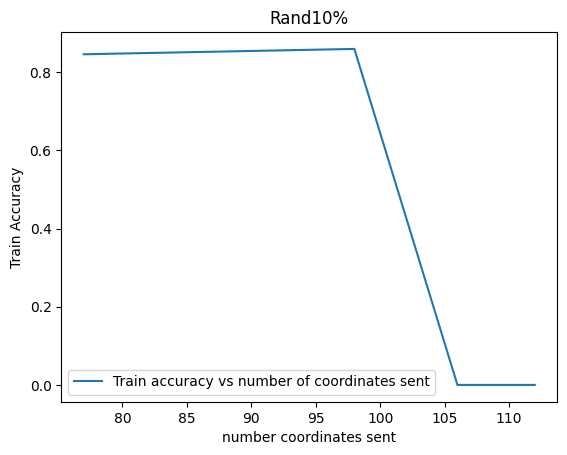

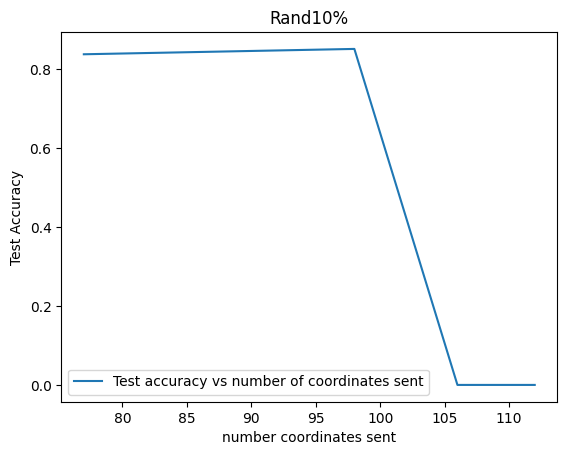

100%|██████████| 100/100 [02:19<00:00,  1.40s/it]


CGD implementation for batchsize 649, took 141.21580982208252 seconds


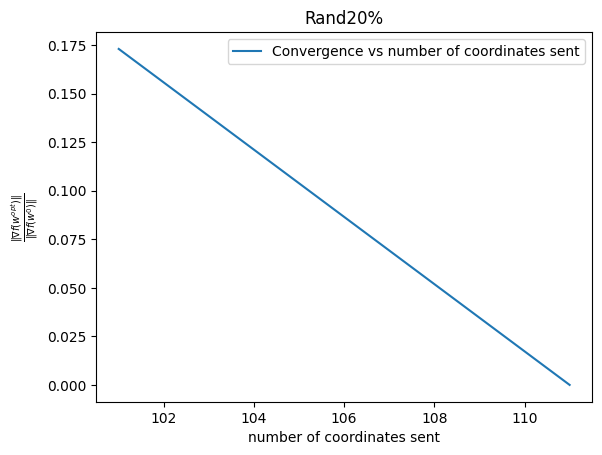

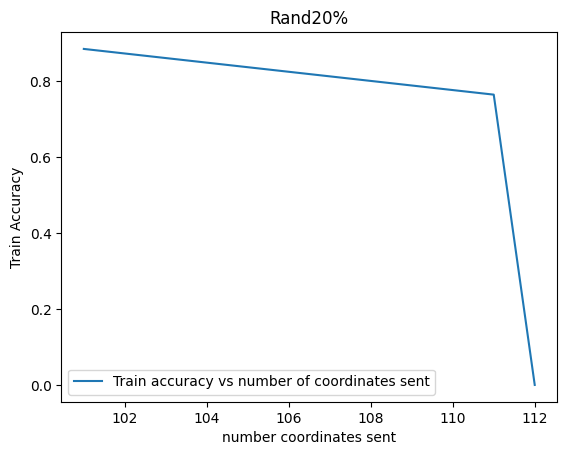

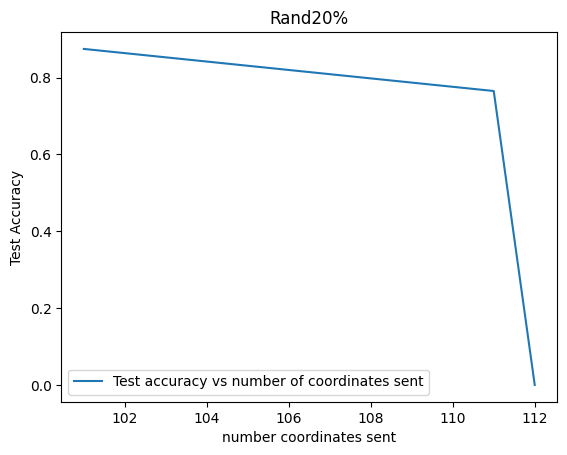

In [95]:
# CGD(nabla_f, w_0, compressor, k, hetero = 0, gamma = None, num_parts = 10,
#        K = 1000, eps = 1e-6, data = (X_train, y_train))

w_0 = np.zeros(X_train[0].shape[0])  # np.random.rand(X_train[0].shape[0])
nabla_f = gradient
compressor = RandK
ks = [1, 5, 10, 20]
for k in ks:
    w_opt, path, num_trn, testacc, trainacc = CGD(nabla_f, w_0, compressor, k)
    plt.title(f'Rand{k}%')
    plt.plot(num_trn, path, label = 'Convergence vs number of coordinates sent')
    plt.xlabel('number of coordinates sent')
    plt.ylabel('$ \\frac{\\| \\nabla f (w^{opt}) \\|}{\\| \\nabla f (w^0)\\|}$')
    plt.legend()
    plt.show()

    plt.title(f'Rand{k}%')
    plt.plot(num_trn, trainacc, label = 'Train accuracy vs number of coordinates sent')
    plt.xlabel('number coordinates sent')
    plt.ylabel('Train Accuracy')
    plt.legend()
    plt.show()

    plt.title(f'Rand{k}%')
    plt.plot(num_trn, testacc, label = 'Test accuracy vs number of coordinates sent')
    plt.xlabel('number coordinates sent')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.show()

For 100 iterations, Rand $20\%$ covers full $112$ coordinates and also seems to have the best performance. Time complexities for different Rand $k\%$ seems to be the same. I would expect Rand $10\%$ to improve for higher iteration number in terms of number of coordinates transmitted.

__c). (2 points)__ Try to tune the step for each case from the previous point. Explain how you determine that the step is "the best" (there is no universal recipe here, just your thoughts)

Draw the comparison plots for different operators and tuned steps for them: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

Taking a cue from $\gamma_k = \frac{1}{k+1}$ and $\gamma_k = \frac{1}{\sqrt{k+1}}$ from previous tasks

100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


CGD implementation for batchsize 649, took 140.72973799705505 seconds


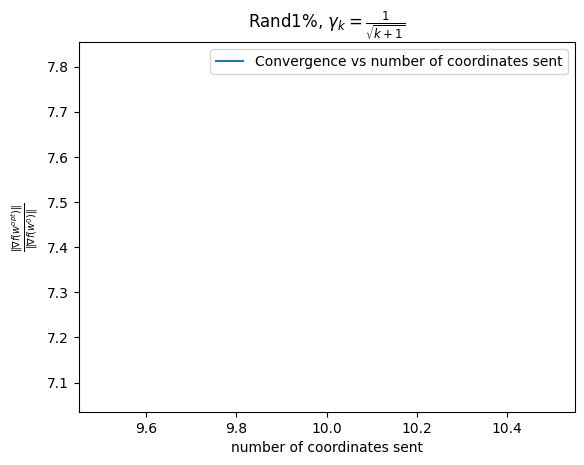

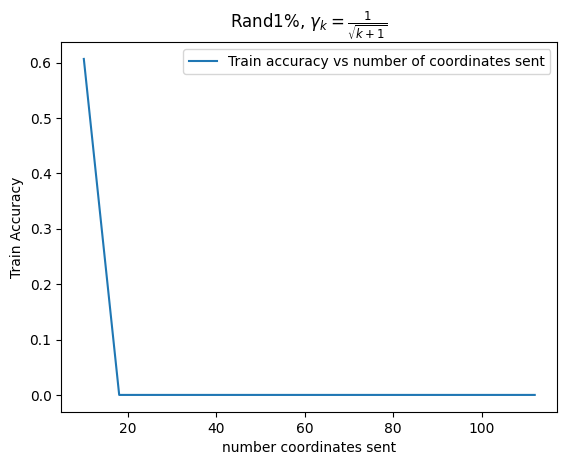

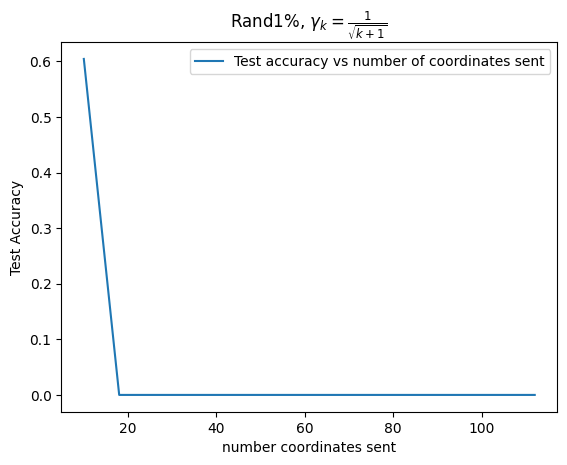

100%|██████████| 100/100 [02:15<00:00,  1.35s/it]


CGD implementation for batchsize 649, took 136.437237739563 seconds


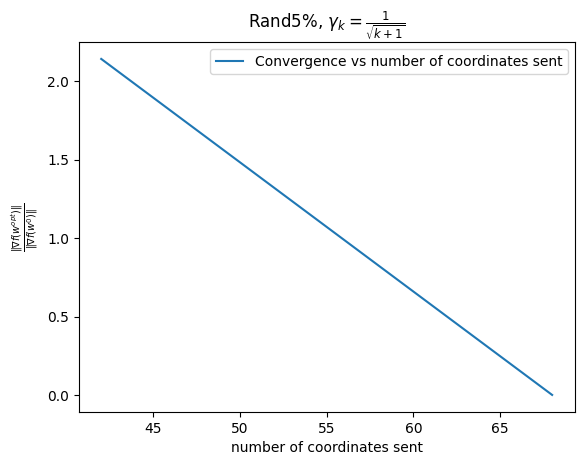

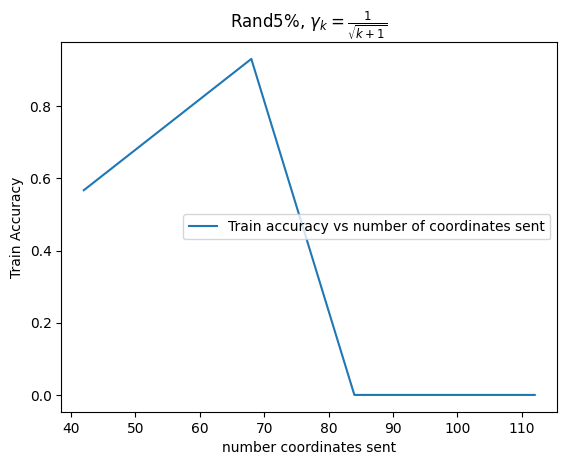

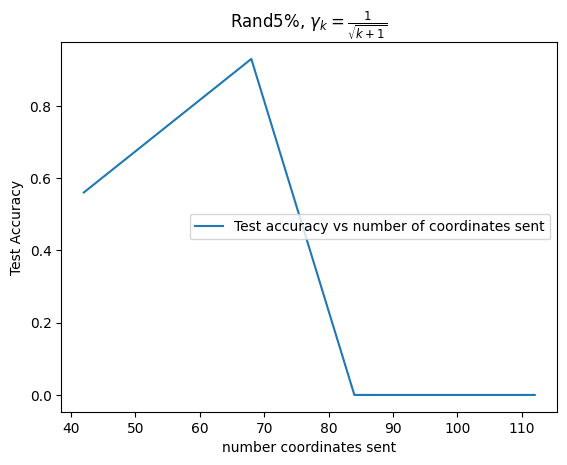

100%|██████████| 100/100 [02:13<00:00,  1.33s/it]


CGD implementation for batchsize 649, took 134.4376745223999 seconds


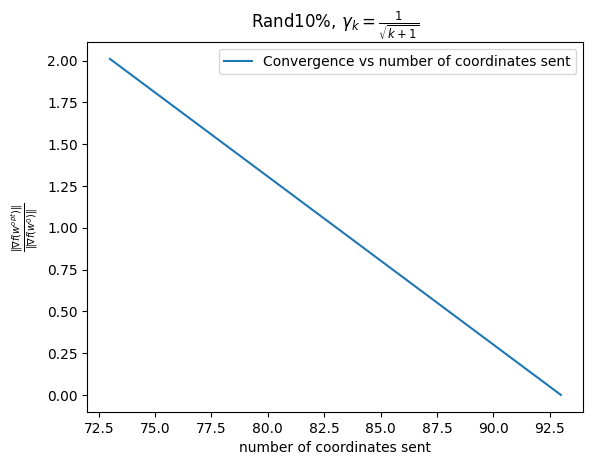

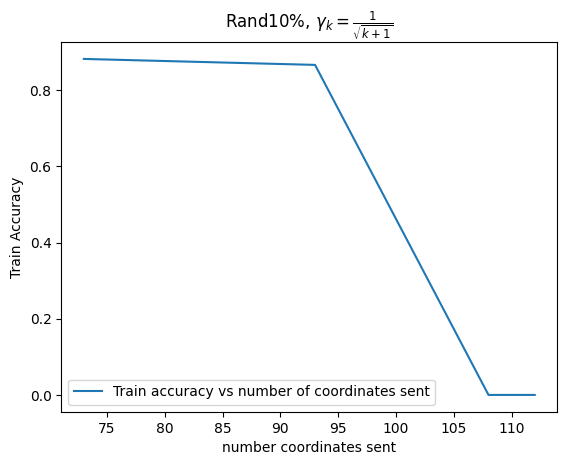

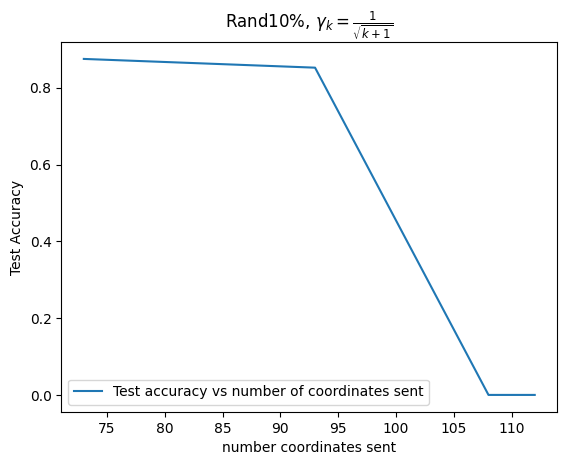

100%|██████████| 100/100 [02:23<00:00,  1.44s/it]


CGD implementation for batchsize 649, took 145.54422092437744 seconds


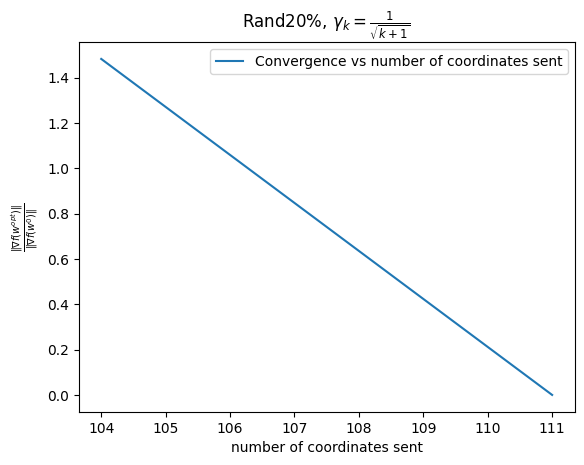

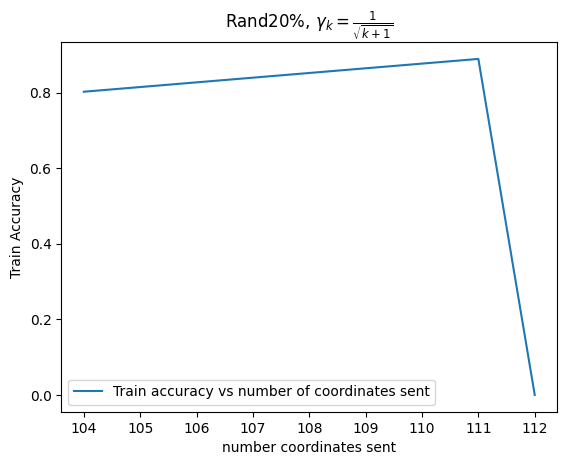

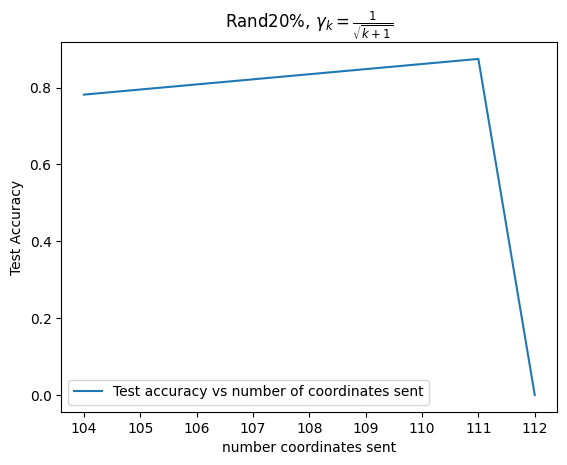

100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


CGD implementation for batchsize 649, took 132.916011095047 seconds


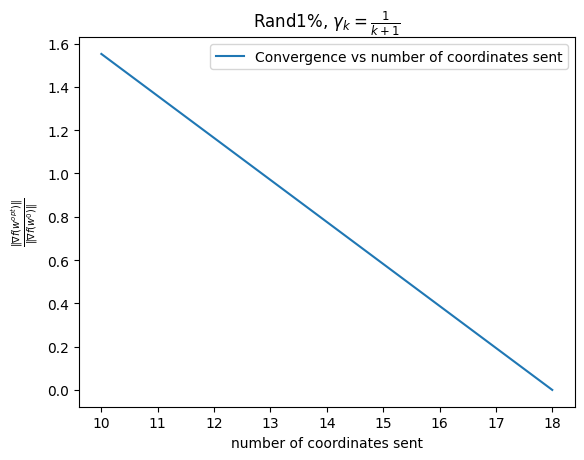

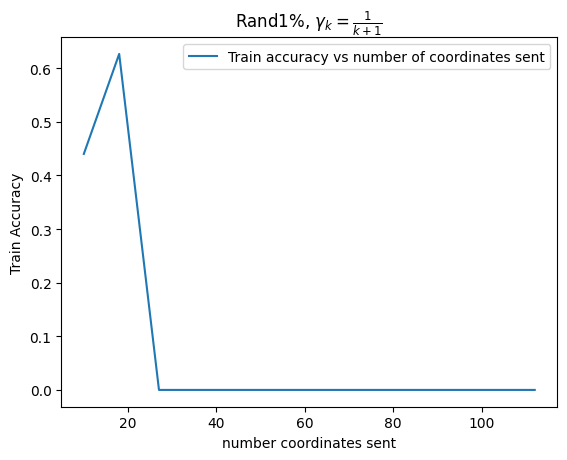

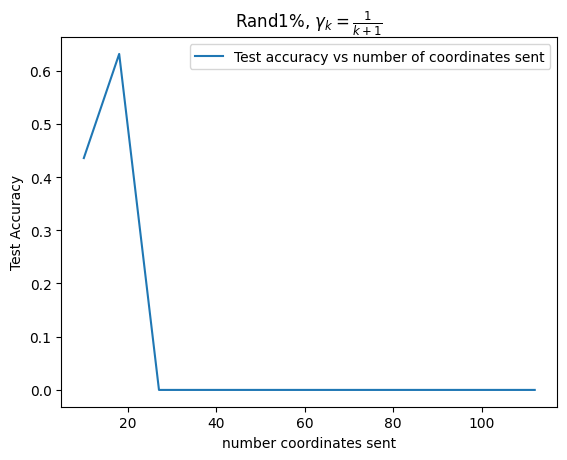

100%|██████████| 100/100 [02:10<00:00,  1.30s/it]

CGD implementation for batchsize 649, took 131.87431144714355 seconds


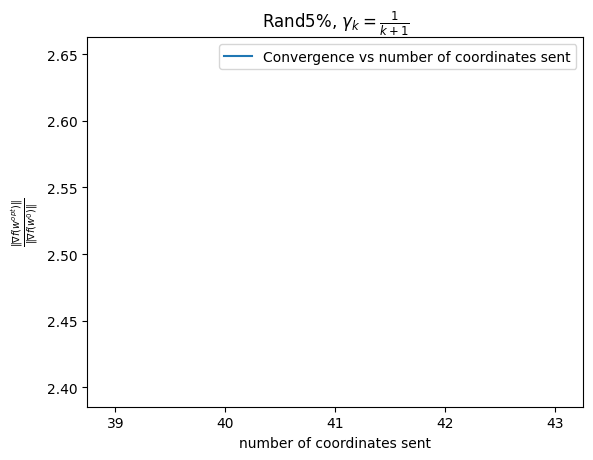

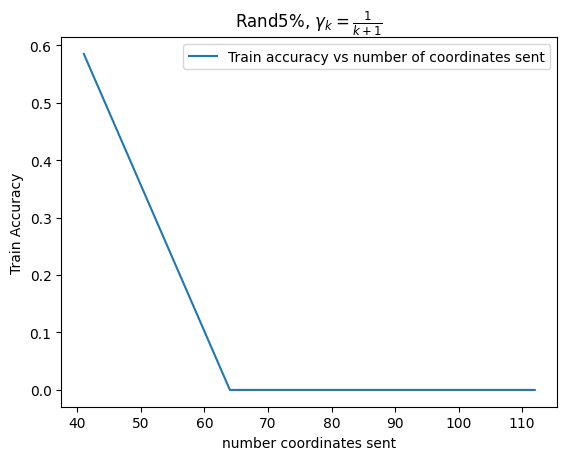

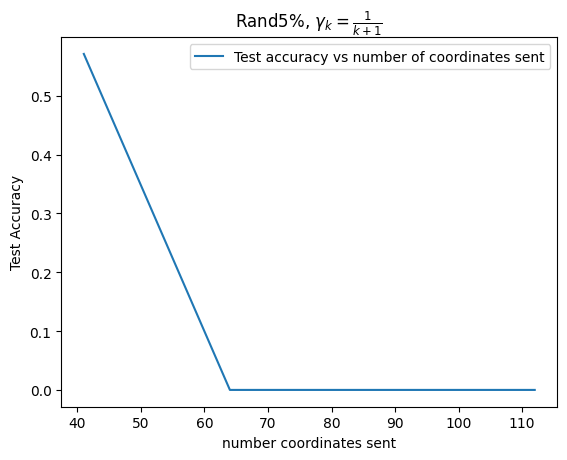

100%|██████████| 100/100 [02:15<00:00,  1.36s/it]


CGD implementation for batchsize 649, took 136.94023942947388 seconds


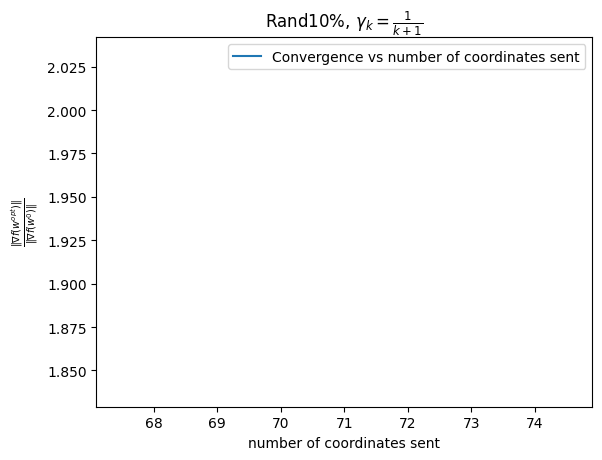

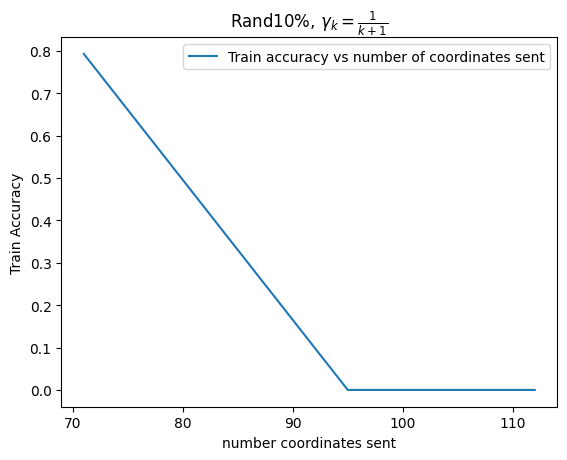

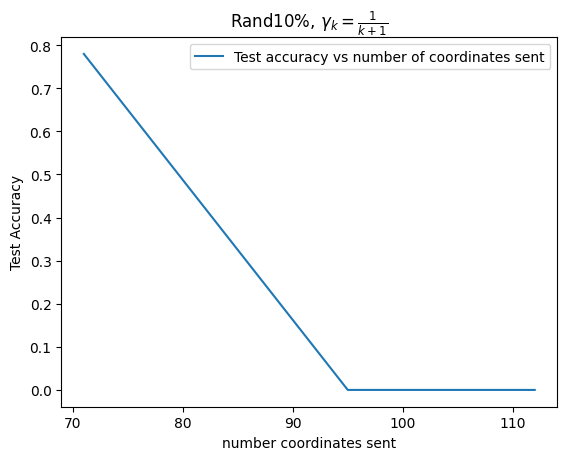

100%|██████████| 100/100 [02:16<00:00,  1.36s/it]


CGD implementation for batchsize 649, took 138.0355682373047 seconds


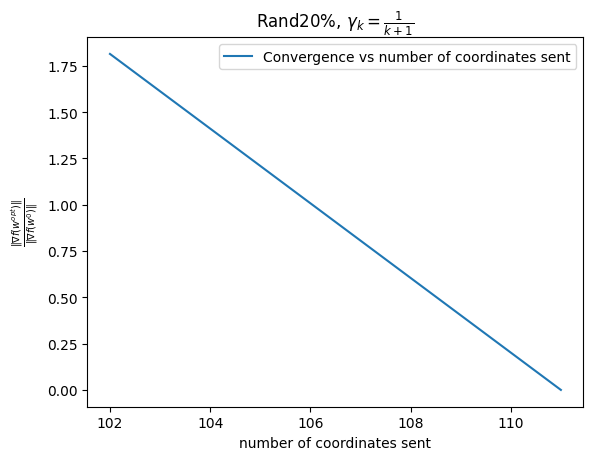

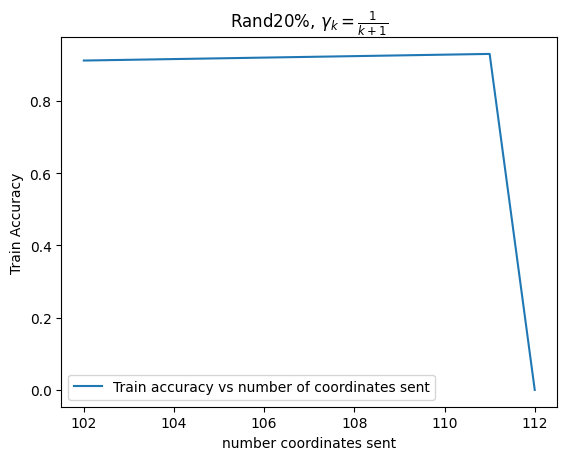

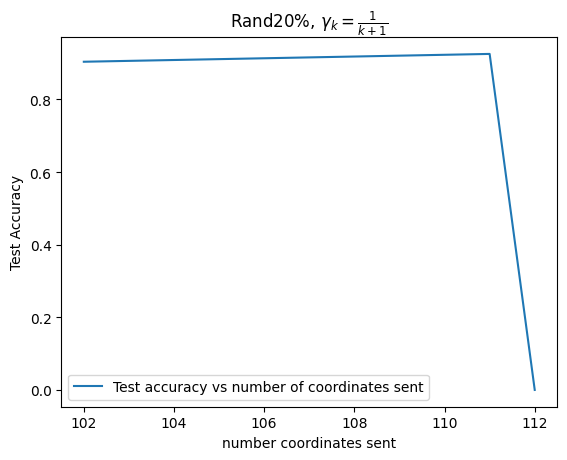

In [96]:
#your solution (Code and Markdown)

# CGD(nabla_f, w_0, compressor, k, hetero = 0, gamma = None, num_parts = 10,
#        K = 1000, eps = 1e-6, data = (X_train, y_train))

gamma_2 = lambda x: 1/np.sqrt(x+1)
gamma_3 = lambda x: 1/(x+1)

ks = [1, 5, 10, 20]
for k in ks:
    w_opt, path, num_trn, testacc, trainacc = CGD(nabla_f, w_0, compressor, k, gamma = gamma_2)
    plt.title(f'Rand{k}%, ' + '$\\gamma_k = \\frac{1}{\\sqrt{k+1}}$')
    plt.plot(num_trn, path, label = 'Convergence vs number of coordinates sent')
    plt.xlabel('number of coordinates sent')
    plt.ylabel('$ \\frac{\\| \\nabla f (w^{opt}) \\|}{\\| \\nabla f (w^0)\\|}$')
    plt.legend()
    plt.show()

    plt.title(f'Rand{k}%, ' + '$\\gamma_k = \\frac{1}{\\sqrt{k+1}}$')
    plt.plot(num_trn, trainacc, label = 'Train accuracy vs number of coordinates sent')
    plt.xlabel('number coordinates sent')
    plt.ylabel('Train Accuracy')
    plt.legend()
    plt.show()

    plt.title(f'Rand{k}%, ' + '$\\gamma_k = \\frac{1}{\\sqrt{k+1}}$')
    plt.plot(num_trn, testacc, label = 'Test accuracy vs number of coordinates sent')
    plt.xlabel('number coordinates sent')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.show()

for k in ks:
    w_opt, path, num_trn, testacc, trainacc = CGD(nabla_f, w_0, compressor, k, gamma = gamma_3)
    plt.title(f'Rand{k}%, ' + '$\\gamma_k = \\frac{1}{k+1}$')
    plt.plot(num_trn, path, label = 'Convergence vs number of coordinates sent')
    plt.xlabel('number of coordinates sent')
    plt.ylabel('$ \\frac{\\| \\nabla f (w^{opt}) \\|}{\\| \\nabla f (w^0)\\|}$')
    plt.legend()
    plt.show()

    plt.title(f'Rand{k}%, ' + '$\\gamma_k = \\frac{1}{k+1}$')
    plt.plot(num_trn, trainacc, label = 'Train accuracy vs number of coordinates sent')
    plt.xlabel('number coordinates sent')
    plt.ylabel('Train Accuracy')
    plt.legend()
    plt.show()

    plt.title(f'Rand{k}%, ' + '$\\gamma_k = \\frac{1}{k+1}$')
    plt.plot(num_trn, testacc, label = 'Test accuracy vs number of coordinates sent')
    plt.xlabel('number coordinates sent')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.show()

As suspected, the convergence (more of accuracy)imrpoves for these step methods.

__d). (2 points)__ Here we fix $s = 10$, $\text{Rand}10\%$ and change power of heterogeneity. Take a step is equal to $L^{-1} (\frac{2 \omega}{s} + 1)^{-1}$ (take into account that for each heterogeneity setting it is better to recompute $L$). Draw the comparison plots for $3-5$ different power of heterogeneity: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

100%|██████████| 100/100 [02:13<00:00,  1.34s/it]

CGD implementation for batchsize 649, took 135.00854420661926 seconds


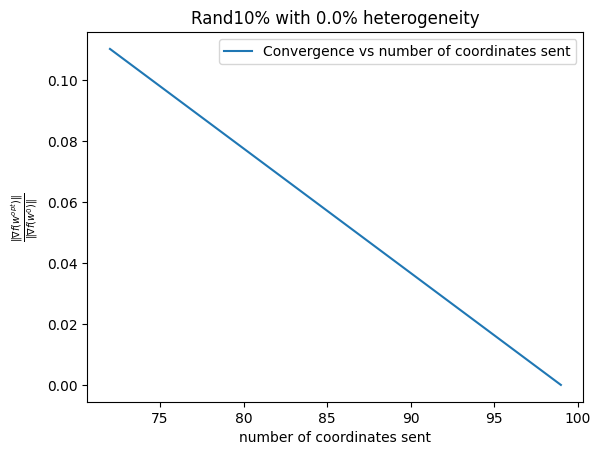

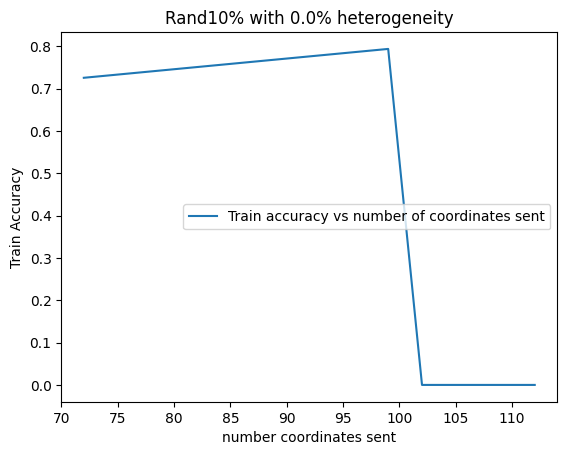

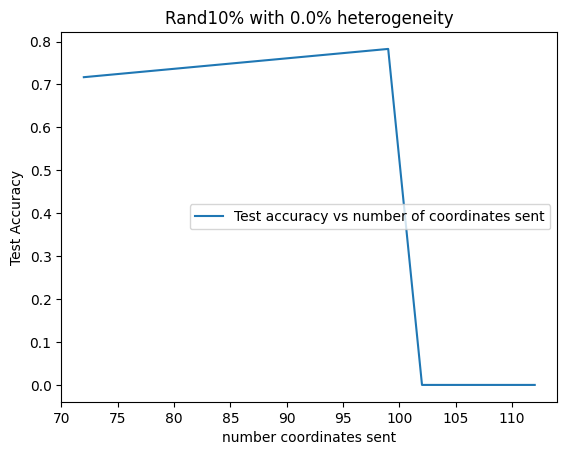

100%|██████████| 100/100 [02:19<00:00,  1.40s/it]

CGD implementation for batchsize 649, took 141.15526938438416 seconds


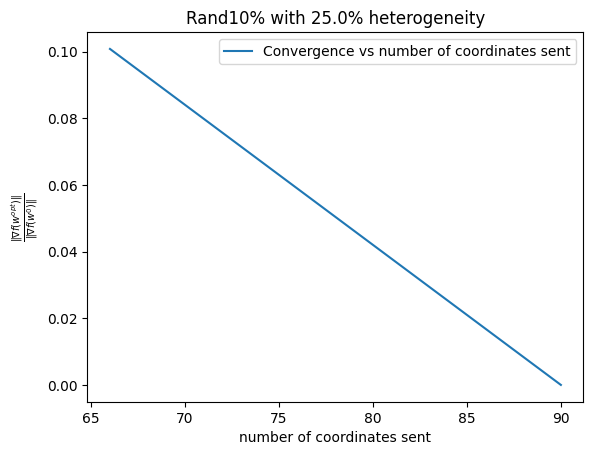

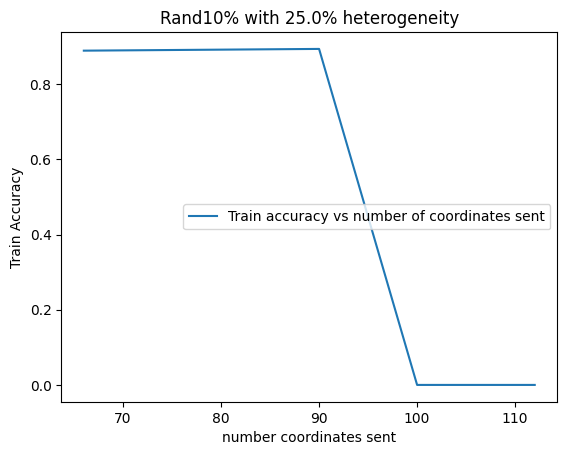

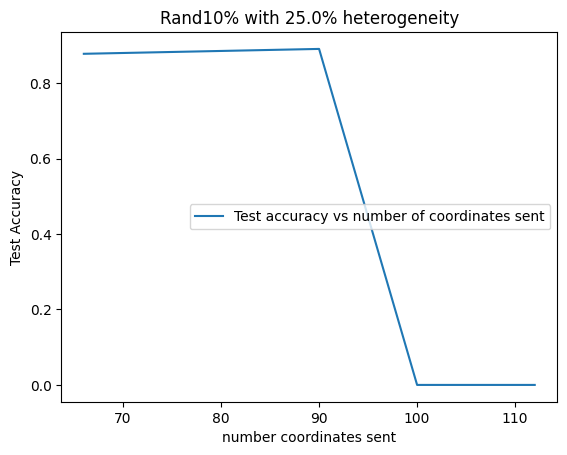

100%|██████████| 100/100 [02:08<00:00,  1.28s/it]

CGD implementation for batchsize 649, took 129.83163404464722 seconds


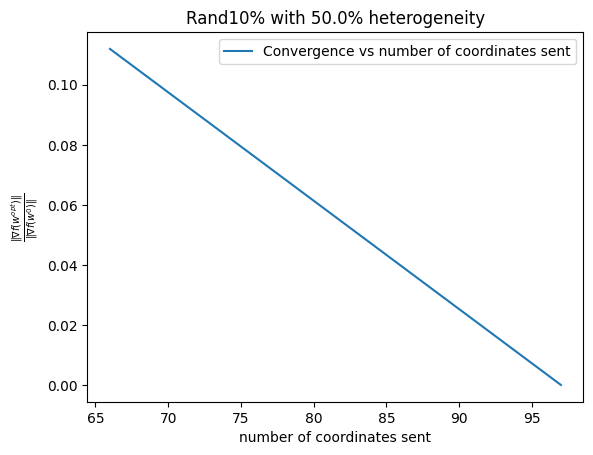

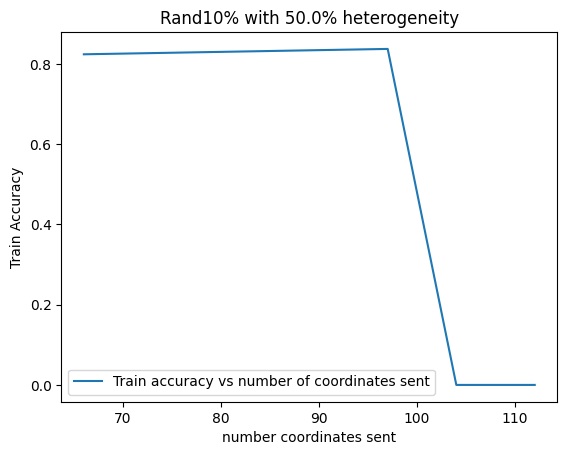

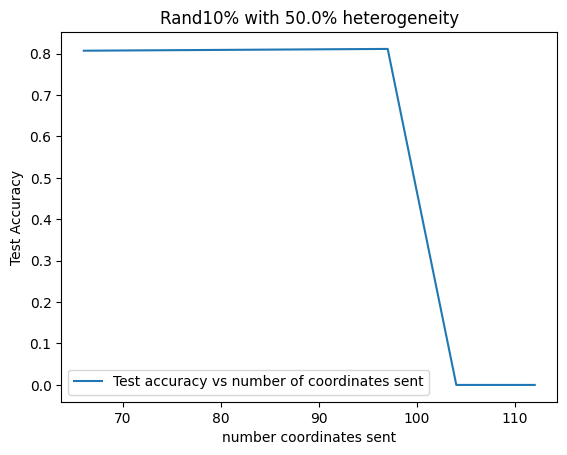

100%|██████████| 100/100 [02:15<00:00,  1.35s/it]

CGD implementation for batchsize 649, took 136.72225713729858 seconds


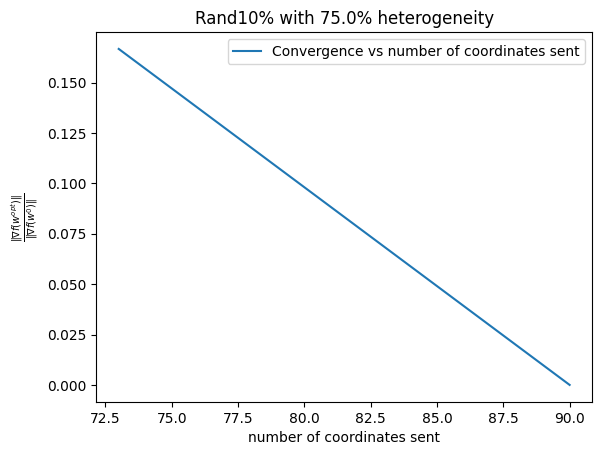

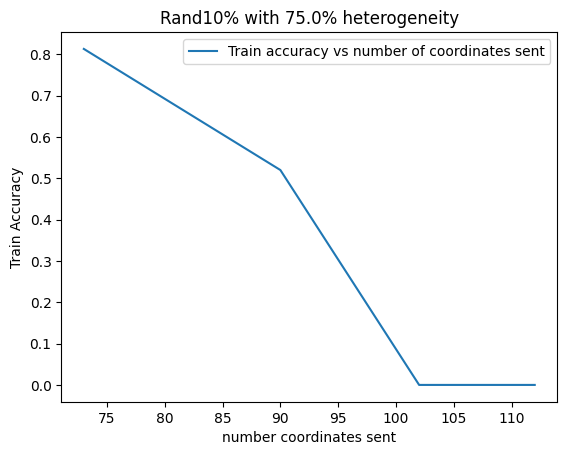

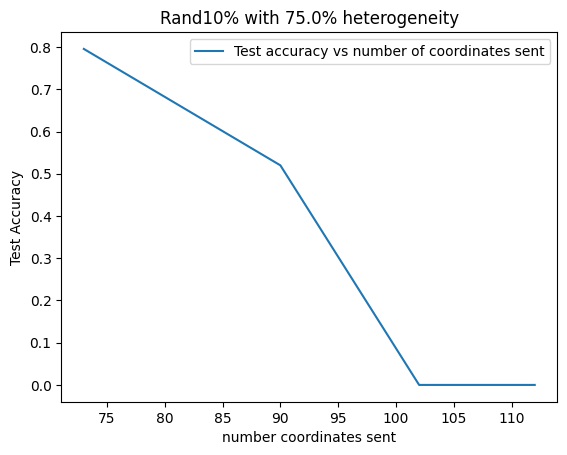

100%|██████████| 100/100 [02:08<00:00,  1.29s/it]

CGD implementation for batchsize 649, took 129.9909703731537 seconds


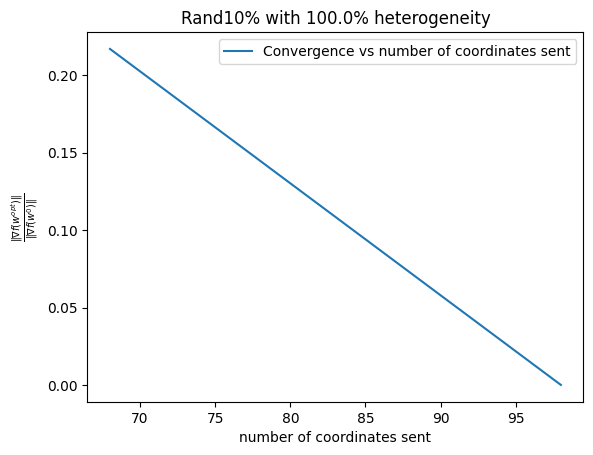

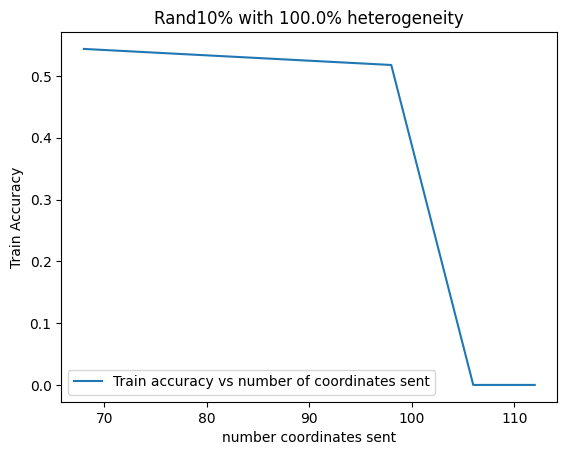

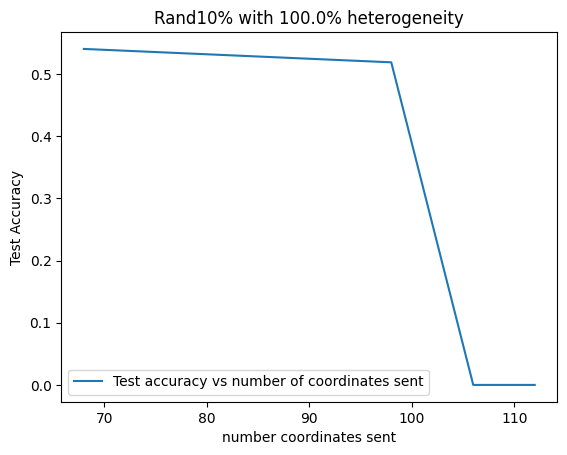

In [97]:
#your solution (Code and Markdown)
heteros = np.linspace(0, 1, 5)
compressor = RandK
k = 10

# CGD(nabla_f, w_0, compressor, k, hetero = 0, gamma = None, num_parts = 10,
#        K = 1000, eps = 1e-6, data = (X_train, y_train))

for hetero in heteros:
    w_opt, path, num_trn, testacc, trainacc = CGD(nabla_f, w_0, compressor, k = k, hetero = hetero)
    plt.title(f'Rand{k}% with {hetero*100}% heterogeneity')
    plt.plot(num_trn, path, label = 'Convergence vs number of coordinates sent')
    plt.xlabel('number of coordinates sent')
    plt.ylabel('$ \\frac{\\| \\nabla f (w^{opt}) \\|}{\\| \\nabla f (w^0)\\|}$')
    plt.legend()
    plt.show()

    plt.title(f'Rand{k}% with {hetero*100}% heterogeneity')
    plt.plot(num_trn, trainacc, label = 'Train accuracy vs number of coordinates sent')
    plt.xlabel('number coordinates sent')
    plt.ylabel('Train Accuracy')
    plt.legend()
    plt.show()

    plt.title(f'Rand{k}% with {hetero*100}% heterogeneity')
    plt.plot(num_trn, testacc, label = 'Test accuracy vs number of coordinates sent')
    plt.xlabel('number coordinates sent')
    plt.ylabel('Test Accuracy')
    plt.legend()
    plt.show()


I observed a **decrease** in accuracy with **increase** in heterogeneity. This suggests that it is better for all machines to have access to same (distribution) data.

__e). (3 points)__ Now we use $s=10$, uniformly distributed data and $\text{Top}10\%$ as compression operators. Compress the information only from the devices to the server. Use two methods: simple distributed gradient descent with compression operators, and distributed gradient descent with error feedback technique (see Algorithm 1 from [article](https://arxiv.org/abs/2002.12410)). For each method, select the step for the "best" convergence. Draw the comparison plots for two approaches without and with error feedback with "best" steps: 1) convergence criterion value versus number of transmitted coordinates from the devices to the server, 2) prediction accuracy versus number of transmitted coordinates from the devices to the server. Make a conclusion.

In [98]:

#your solution (Code and Markdown)

def CGD_err(nabla_f, w_0, compressor, k, hetero = 0, gamma = None, num_parts = 10,
        K = 100, eps = 1e-6, data = (X_train, y_train)):
    '''
    Finds the zero of nabla_f using stochastic gradient descent with compression and error feedback

    Parameters
    nabla_f    :   Gradient of the cost function
    w_0        :   Start point
    compressor :   Compression operator
    k          :   Parameter for compressor
    hetero     :   Heterogeinty of the data_split [0, 1]
    gamma      :   Step Method
    num_parts  :   Number of independent batches to split the data into
    K          :   Number if iterations
    eps        :   Accuracy
    data       :   Data to train the algorithm on

    Return
    w_opt   :   Optimal point found by the algorithm
    path    :   The path of the algorithm = [norm(w_0), norm(w_1), ..., norm(w_K)]
    num_trn :   Number of transmitted coordinates per iteration
    testacc :   Prediction accuracy per iteration on test set
    trainacc:   Prediction accuracy per iteration on train set
    '''
    start = time.time()
    b = len(data[0])//num_parts
    batches =  split_data_heterogeneously(hetero, b, data)
    batches = batches[:num_parts]

    w_prev = w_0
    C = np.linalg.norm(nabla_f(w_0, data[0], data[1]))
    path = []
    num_trn = []
    testacc = []
    trainacc = []
    d = len(w_0)
    w = d/int(d*k/100) - 1
    s = num_parts
    w_new = np.zeros_like(w_prev)
    err = np.zeros_like(w_prev)
    mask = np.zeros_like(w_prev) # Set to False
    if not gamma:
        gamma = lambda x: gamma_CGD(x, w, s)
        for _ in tqdm(range(K)):
            for i in range(num_parts):
                batch = batches[i]  # Worker i has access to batch i
                eta_gamma = gamma(np.array(batch[0])) * nabla_f(w_prev, np.array(batch[0]), np.array(batch[1]))
                w_new, m = compressor(k, err + eta_gamma)
                err += err + eta_gamma - w_new # Error feedback
                mask += m # Get coordinates transmitted

            # Back to server
            # Update weights
            w_new /= num_parts

            path.append(np.linalg.norm(w_new - w_prev)/C)
            num_trn.append(sum(mask > 0))
            testacc.append(sum(predict(w_new, X_test) == y_test)/len(y_test))
            trainacc.append(sum(predict(w_new, X_train) == y_train)/len(y_train))
            #if np.all(100000*np.abs(w_new - w_prev) <= eps):
                #break
            # Broadcast new weights to all nodes
            w_prev = w_new
    else:
        for i in tqdm(range(K)):
            for j in range(num_parts):
                batch = batches[j] # Worker j has access to batch j
                eta_gamma = gamma(i) * nabla_f(w_prev, np.array(batch[0]), np.array(batch[1]))
                w_new, m = compressor(k, err + eta_gamma)
                err += err + eta_gamma - w_new # Error feedback
                mask += m # Get coordiinates transmitted
            # Update weights
            w_new /= num_parts

            path.append(np.linalg.norm(w_new - w_prev)/C)
            num_trn.append(sum(mask > 0))
            testacc.append(sum(predict(w_new, X_test) == y_test)/len(y_test))
            trainacc.append(sum(predict(w_new, X_train) == y_train)/len(y_train))
            #if np.all(100000*np.abs(w_new - w_prev) <= eps):
                #break
            # Broadcast new weights to all nodes
            w_prev = w_new
    w_opt = w_new
    end = time.time()
    print(f'CGD implementation with error feedback for batchsize {b}, took {end - start} seconds')
    return w_opt, path, num_trn, testacc, trainacc

100%|██████████| 100/100 [02:11<00:00,  1.32s/it]

CGD implementation for batchsize 649, took 133.1788592338562 seconds


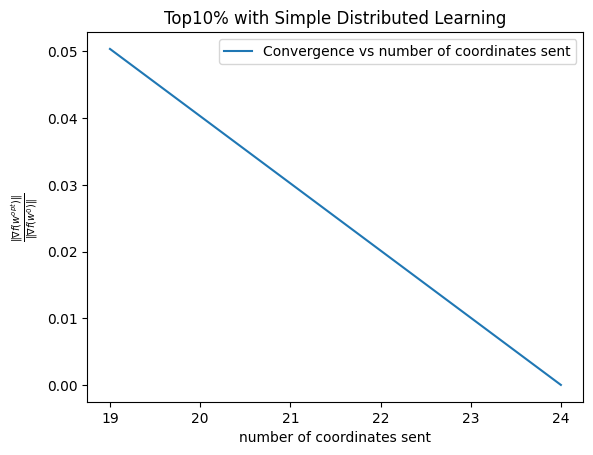

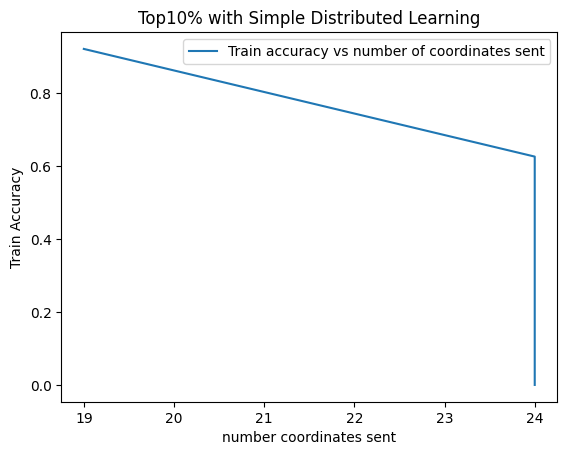

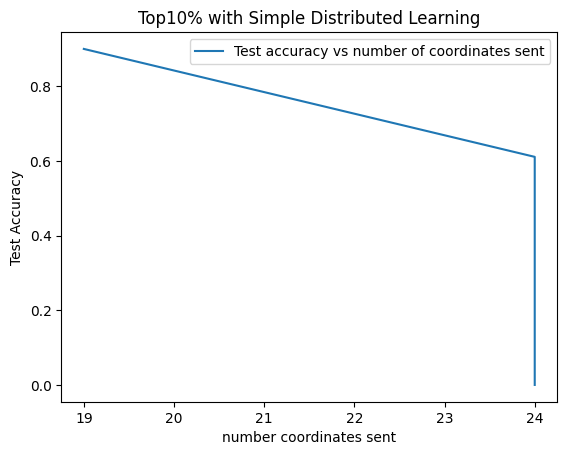

100%|██████████| 100/100 [02:12<00:00,  1.33s/it]

CGD implementation with error feedback for batchsize 649, took 134.41359877586365 seconds


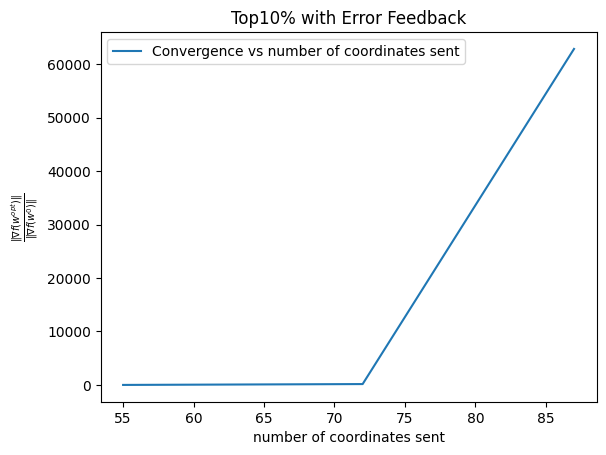

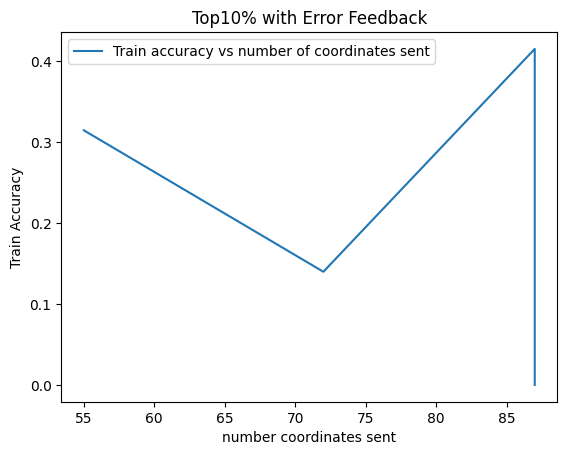

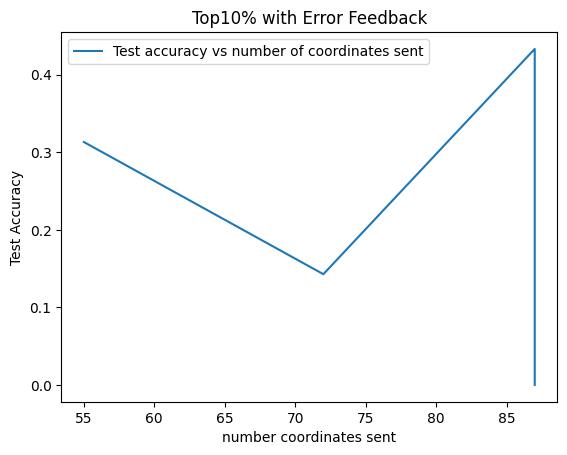

In [99]:
compressor = TopK
k = 10
w_0 = np.zeros(X_train[0].shape[0])
nabla_f = gradient
hetero = 0 # For Uniform distribution

w_opt, path, num_trn, testacc, trainacc = CGD(nabla_f, w_0, compressor, k = k, hetero = hetero)
plt.title(f'Top{k}% with Simple Distributed Learning')
plt.plot(num_trn, path, label = 'Convergence vs number of coordinates sent')
plt.xlabel('number of coordinates sent')
plt.ylabel('$ \\frac{\\| \\nabla f (w^{opt}) \\|}{\\| \\nabla f (w^0)\\|}$')
plt.legend()
plt.show()

plt.title(f'Top{k}% with Simple Distributed Learning')
plt.plot(num_trn, trainacc, label = 'Train accuracy vs number of coordinates sent')
plt.xlabel('number coordinates sent')
plt.ylabel('Train Accuracy')
plt.legend()
plt.show()

plt.title(f'Top{k}% with Simple Distributed Learning')
plt.plot(num_trn, testacc, label = 'Test accuracy vs number of coordinates sent')
plt.xlabel('number coordinates sent')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

w_opt, path, num_trn, testacc, trainacc = CGD_err(nabla_f, w_0, compressor, k = k, hetero = hetero)
plt.title(f'Top{k}% with Error Feedback')
plt.plot(num_trn, path, label = 'Convergence vs number of coordinates sent')
plt.xlabel('number of coordinates sent')
plt.ylabel('$ \\frac{\\| \\nabla f (w^{opt}) \\|}{\\| \\nabla f (w^0)\\|}$')
plt.legend()
plt.show()

plt.title(f'Top{k}% with Error Feedback')
plt.plot(num_trn, trainacc, label = 'Train accuracy vs number of coordinates sent')
plt.xlabel('number coordinates sent')
plt.ylabel('Train Accuracy')
plt.legend()
plt.show()

plt.title(f'Top{k}% with Error Feedback')
plt.plot(num_trn, testacc, label = 'Test accuracy vs number of coordinates sent')
plt.xlabel('number coordinates sent')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

I observed that with error feedback, the biasness of TopK was reduced in the sense that more coordinates were sent to the server from the device than in the simple distributed learning, but accuracy for error feedback was lower. Perhaps varying the heterogeneity of the distribution might help? Or increasing the number of iterations?